## Setup

In [1]:
%run setup.ipynb
%matplotlib notebook
%reload_ext autoreload
%autoreload 1
%aimport hapclust

In [2]:
# setup callset - needed for variant annotations
callset_pass = phase1_ar31.callset_pass
pos_pass = allel.SortedIndex(callset_pass['2L/variants/POS'])
ann_pass = callset_pass['2L/variants/ANN'][:][['Annotation', 'HGVS_p']]

In [3]:
# setup haplotypes
callset_phased = phase1_ar31.callset_phased
genotypes_phased = allel.GenotypeDaskArray(callset_phased['2L/calldata/genotype'])
pos_phased = allel.SortedIndex(callset_phased['2L/variants/POS'])

In [4]:
pos_kdr_s = 2422651
pos_kdr_f = 2422652

In [5]:
# define region for EHH analysis
loc_region = pos_phased.locate_range(0, 4000000)
pos_phased_region = pos_phased[loc_region]
pos_phased_region

<SortedIndex shape=(163963,) dtype=int32>
[44688, 44691, 44732, 44736, 44756, ..., 3997372, 3997373, 3997378, 3997381, 3997386]

In [6]:
# locate the intersection - needed to tie in annotations
loc1, _ = pos_pass.locate_intersection(pos_phased_region)
np.count_nonzero(loc1)

163963

In [7]:
ann_phased_region = ann_pass[loc1]
ann_phased_region

array([(b'intergenic_region', b'.'), (b'intergenic_region', b'.'),
       (b'intergenic_region', b'.'), ...,
       (b'downstream_gene_variant', b'.'),
       (b'downstream_gene_variant', b'.'),
       (b'downstream_gene_variant', b'.')], 
      dtype=[('Annotation', 'S34'), ('HGVS_p', 'S14')])

In [8]:
collections.Counter(ann_phased_region['Annotation'])

Counter({b'3_prime_UTR_variant': 2941,
         b'5_prime_UTR_premature_start_codon_': 306,
         b'5_prime_UTR_variant': 1677,
         b'downstream_gene_variant': 18539,
         b'initiator_codon_variant': 3,
         b'intergenic_region': 54849,
         b'intragenic_variant': 48,
         b'intron_variant': 32362,
         b'missense_variant': 5805,
         b'missense_variant&splice_region_var': 70,
         b'splice_acceptor_variant&intron_var': 24,
         b'splice_donor_variant&intron_varian': 27,
         b'splice_region_variant': 36,
         b'splice_region_variant&intron_varia': 649,
         b'splice_region_variant&stop_retaine': 5,
         b'splice_region_variant&synonymous_v': 87,
         b'start_lost': 9,
         b'stop_gained': 37,
         b'stop_lost&splice_region_variant': 4,
         b'stop_retained_variant': 5,
         b'synonymous_variant': 8636,
         b'upstream_gene_variant': 37844})

In [9]:
# exclude cross parents
haps_phased_region = genotypes_phased[loc_region].to_haplotypes()[:, :-16].compute()

In [10]:
ac_phased_region = haps_phased_region.count_alleles(max_allele=1)
ac_phased_region

<AlleleCountsArray shape=(163963, 2) dtype=int32>
1529    1
1528    2
1528    2
...
1527    3
1529    1
1527    3

In [11]:
region_vgsc = SeqFeature('2L', 2358158, 2431617, label='Vgsc')
region_vgsc

<SeqFeature 'Vgsc' 2L:2358158-2431617>

In [12]:
loc_vgsc = pos_phased_region.locate_range(region_vgsc.start, region_vgsc.end)
loc_vgsc

slice(24471, 26181, None)

In [13]:
haps_vgsc = haps_phased_region[loc_vgsc]
haps_vgsc

<HaplotypeArray shape=(1710, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [14]:
ac_vgsc = haps_vgsc.count_alleles(max_allele=1)
ac_vgsc

<AlleleCountsArray shape=(1710, 2) dtype=int32>
1529    1
1457   73
1528    2
...
1513   17
1525    5
1519   11

In [15]:
ann_vgsc = ann_phased_region[loc_vgsc]

In [16]:
loc_vgsc_missense = (ann_vgsc['Annotation'] == b'missense_variant') & (ac_vgsc[:, 1] > 7)
np.count_nonzero(loc_vgsc_missense)

16

In [17]:
haps_vgsc_missense = haps_vgsc[loc_vgsc_missense]

In [18]:
lbl_vgsc_missense = [l[2:] for l in ann_vgsc[loc_vgsc_missense]['HGVS_p'].astype('U')]
lbl_vgsc_missense

['Arg254Lys',
 'Asp466His',
 'Thr791Met',
 'Leu995Ser',
 'Leu995Phe',
 'Ala1125Val',
 'Ile1527Thr',
 'Glu1597Gly',
 'Ala1746Ser',
 'Val1853Ile',
 'Ile1868Thr',
 'Pro1874Ser',
 'Pro1874Leu',
 'Phe1920Ser',
 'Ala1934Val',
 'Ile1940Thr']

In [19]:
# define types of variants to include in EHH analysis - should be mostly neutral
loc_type_neutral = ((ann_phased_region['Annotation'] == b'intergenic_region') | 
                    (ann_phased_region['Annotation'] == b'intron_variant') |
                    (ann_phased_region['Annotation'] == b'downstream_gene_variant') |
                    (ann_phased_region['Annotation'] == b'upstream_gene_variant') |
                    (ann_phased_region['Annotation'] == b'synonymous_variant') |
                    (ann_phased_region['Annotation'] == b'3_prime_UTR_variant') |
                    (ann_phased_region['Annotation'] == b'5_prime_UTR_variant') 
                    )
np.count_nonzero(loc_type_neutral), loc_type_neutral.shape

(156848, (163963,))

In [20]:
# locate singletons - will exclude from EHH analysis
loc_sgl = ac_phased_region.min(axis=1) == 1
loc_nosgl = ac_phased_region.min(axis=1) > 1
np.count_nonzero(loc_sgl), np.count_nonzero(loc_nosgl), loc_nosgl.shape

(52221, 111611, (163963,))

In [21]:
# these are the variants to use for EHH
loc_ehh = loc_type_neutral & loc_nosgl
np.count_nonzero(loc_ehh), loc_ehh.shape

(107531, (163963,))

In [22]:
# these are the variants to use for mutational distance
#loc_mut = loc_sgl
# include non-neutral mutations
loc_mut = loc_sgl | ~loc_type_neutral
np.count_nonzero(loc_mut), loc_mut.shape

(56311, (163963,))

In [23]:
haps_mut = haps_phased_region[loc_mut]
haps_mut

<HaplotypeArray shape=(56311, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [24]:
haps_ehh = haps_phased_region[loc_ehh]
haps_ehh

<HaplotypeArray shape=(107531, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
1 1 1 1 1 ... 1 1 1 1 1
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [25]:
pos_ehh = pos_phased_region[loc_ehh]
pos_ehh

<SortedIndex shape=(107531,) dtype=int32>
[44691, 44732, 44756, 44767, 44872, ..., 3997366, 3997367, 3997373, 3997378, 3997386]

In [26]:
pos_mut = pos_phased_region[loc_mut]
pos_mut

<SortedIndex shape=(56311,) dtype=int32>
[44688, 44736, 44887, 44904, 44910, ..., 3997357, 3997362, 3997371, 3997372, 3997381]

In [27]:
pos_mut.locate_key(pos_kdr_s)

10210

In [28]:
pos_mut.locate_key(pos_kdr_f)

10211

In [29]:
# read in haplotype metadata to get population
df_haplotypes = phase1_ar31.df_haplotypes
df_haplotypes = df_haplotypes[df_haplotypes.population != 'colony']
df_haplotypes.head()

label   ox_code population                             label_aug  \
index                                                                         
0      AB0085-Ca  AB0085-C        BFS  AB0085-Ca [Burkina Faso, Pala, S, F]   
1      AB0085-Cb  AB0085-C        BFS  AB0085-Cb [Burkina Faso, Pala, S, F]   
2      AB0087-Ca  AB0087-C        BFM  AB0087-Ca [Burkina Faso, Bana, M, F]   
3      AB0087-Cb  AB0087-C        BFM  AB0087-Cb [Burkina Faso, Bana, M, F]   
4      AB0088-Ca  AB0088-C        BFM  AB0088-Ca [Burkina Faso, Bana, M, F]   

            country region sex m_s  kt_2la  kt_2rb  
index                                               
0      Burkina Faso   Pala   F   S     2.0     2.0  
1      Burkina Faso   Pala   F   S     2.0     2.0  
2      Burkina Faso   Bana   F   M     2.0     1.0  
3      Burkina Faso   Bana   F   M     2.0     1.0  
4      Burkina Faso   Bana   F   M     2.0     0.0

In [30]:
core_pos = pos_kdr_f

In [31]:
dist_ehh_right, dist_ehh_left, haps_ehh_right, haps_ehh_left = hapclust.split_flanks(
    haps_ehh, pos_ehh, core_pos
)

In [32]:
dist_ehh_right

array([     45,     255,     258, ..., 1574721, 1574726, 1574734], dtype=int32)

In [33]:
dist_ehh_left

array([    108,     250,     270, ..., 2377896, 2377920, 2377961], dtype=int32)

In [34]:
dist_ehh_right.shape, dist_ehh_left.shape

((91777,), (15754,))

In [35]:
dist_ehh_right.min(), dist_ehh_left.min()

(45, 108)

In [36]:
dist_mut_right, dist_mut_left, haps_mut_right, haps_mut_left = hapclust.split_flanks(
    haps_mut, pos_mut, core_pos
)

In [37]:
dist_mut_right

array([      0,      82,     353, ..., 1574719, 1574720, 1574729], dtype=int32)

In [38]:
dist_mut_left

array([      1,     166,     505, ..., 2377765, 2377916, 2377964], dtype=int32)

In [39]:
dist_mut_right.shape, dist_mut_left.shape

((46100,), (10211,))

In [40]:
dist_mut_right.min(), dist_mut_left.min()

(0, 1)

In [41]:
haps_ehh_left.shape, haps_ehh_right.shape, haps_mut_left.shape, haps_mut_right.shape

((15754, 1530), (91777, 1530), (10211, 1530), (46100, 1530))

In [42]:
is_accessible = phase1_ar3.accessibility['2L/is_accessible'][:]

## Shared haplotype length

In [43]:
idx_sorted_right, nspl_right, nspd_right, muts_right = hapclust.neighbour_haplotype_sharing(
    haps_ehh_right, haps_mut_right, dist_ehh_right, dist_mut_right
)

In [44]:
idx_sorted_left, nspl_left, nspd_left, muts_left = hapclust.neighbour_haplotype_sharing(
    haps_ehh_left, haps_mut_left, dist_ehh_left, dist_mut_left
)

In [45]:
nspl_right.min(), nspl_right.max()

(0, 76267)

In [46]:
nspl_left.min(), nspl_left.max()

(0, 15754)

In [47]:
nspd_right.min(), nspd_right.max()

(45, 1437047)

In [48]:
nspd_left.min(), nspd_left.max()

(108, 2377961)

In [49]:
muts_right.min(), muts_right.max()

(0, 14)

In [50]:
muts_left.min(), muts_left.max()

(0, 23)

In [51]:
nspd_right_accessible = hapclust.haplotype_accessible_length(nspd_right, core_pos=core_pos, is_accessible=is_accessible, flank='right')
nspd_left_accessible = hapclust.haplotype_accessible_length(nspd_left, core_pos=core_pos, is_accessible=is_accessible, flank='left')

<IPython.core.display.Javascript object>


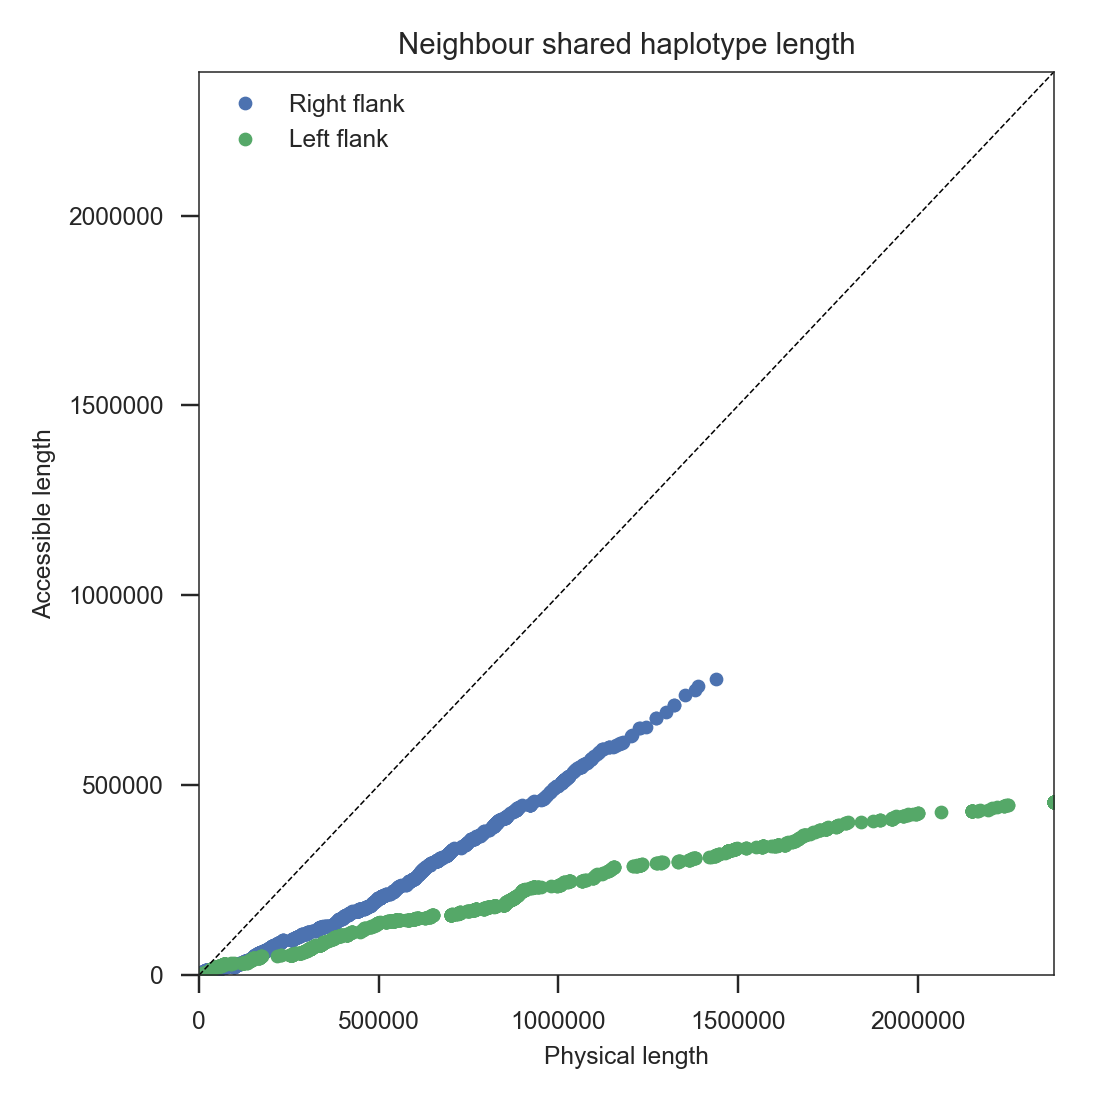

In [52]:
fig, ax = plt.subplots(figsize=(5, 5))
x = nspd_right
y = nspd_right_accessible
ax.plot(x, y, linestyle=' ', marker='o', markersize=4, label='Right flank')
x = nspd_left
y = nspd_left_accessible
ax.plot(x, y, linestyle=' ', marker='o', markersize=4, label='Left flank')
ax.set_xlabel('Physical length')
ax.set_ylabel('Accessible length')
lim = 0, x.max()
ax.set_xlim(*lim)
ax.set_ylim(*lim)
ax.plot(lim, lim, 'k--')
ax.legend()
ax.set_title('Neighbour shared haplotype length')
fig.tight_layout();

In [53]:
# 1 cM/Mb convert to M/bp
1 / (1e2 * 1e6)

1e-08

In [54]:
# assume constant recombination rate
rr_right = 1.5e-8
rr_left = rr_right * 0.37

# assumed mutation rate
mu_right = 3.5e-9
mu_left = 0.61 * mu_right


<IPython.core.display.Javascript object>


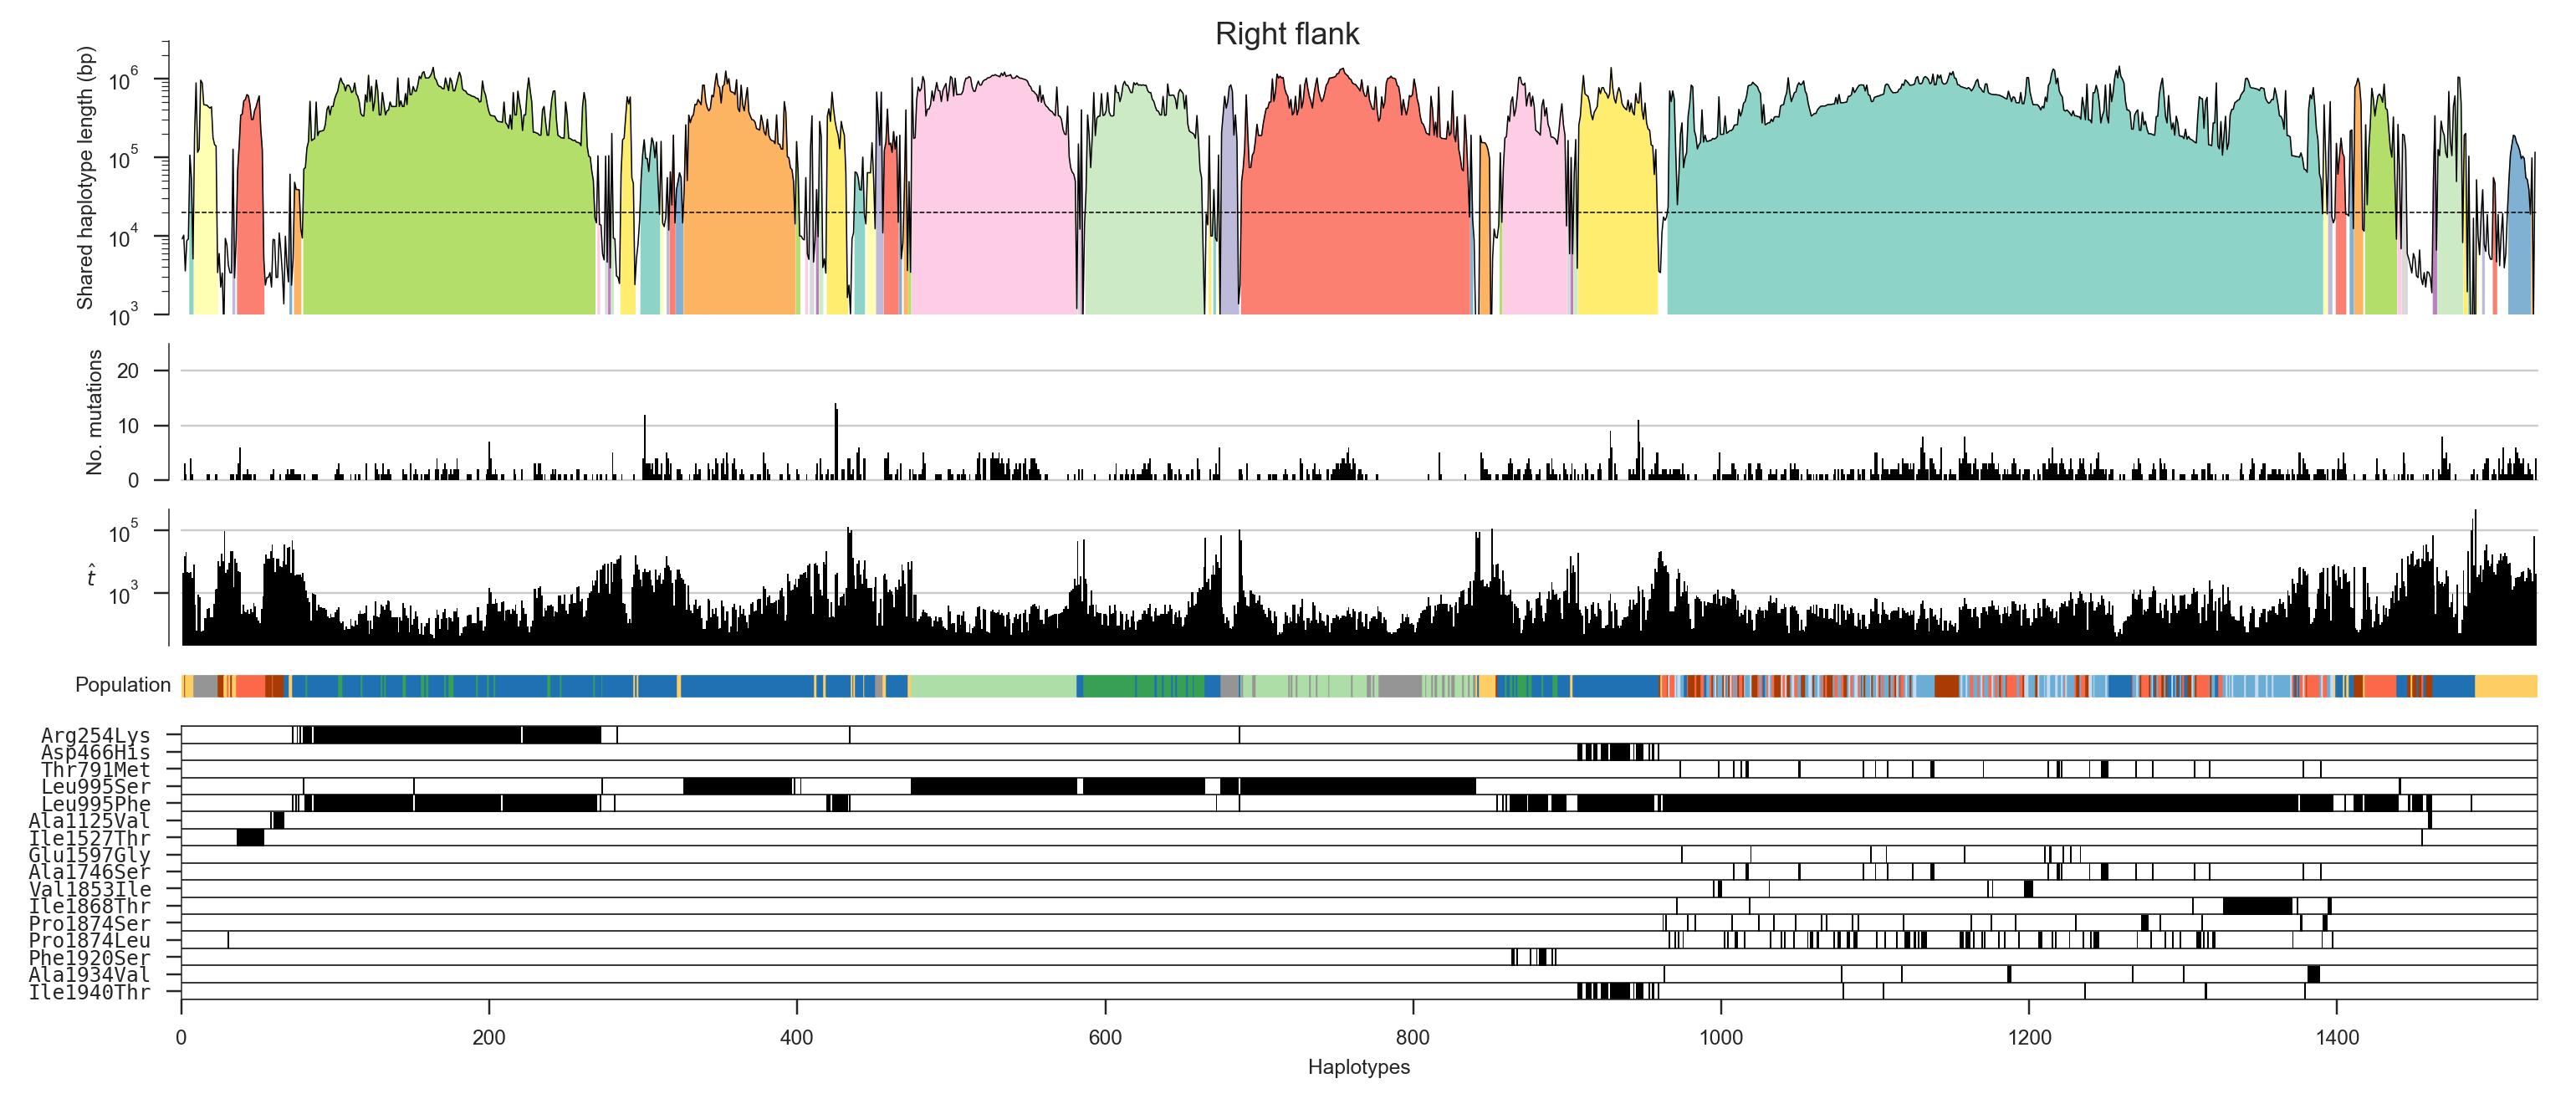

In [55]:
pops_right = df_haplotypes.population[idx_sorted_right]
pop_colors_right = [phase1_ar3.pop_colors[p] for p in pops_right]

fig = plt.figure(figsize=(14, 6))
hapclust.fig_neighbour_haplotype_sharing(nspd=nspd_right, 
                                         nspd_accessible=nspd_right_accessible,
                                         muts=muts_right, 
                                         haps_display=haps_vgsc_missense[:, idx_sorted_right],
                                         haps_display_vlbl=lbl_vgsc_missense,
                                         pop_colors=pop_colors_right,
                                         nspd_cut=2e4,
                                         nspd_ylim=(1e3, 3e6),
                                         that_ylim=(2e1, 5e5),
                                         muts_ylim=(0, 25),
                                         mu=mu_right, rr=rr_right,
                                         fig=fig)
fig.suptitle('Right flank');

<IPython.core.display.Javascript object>


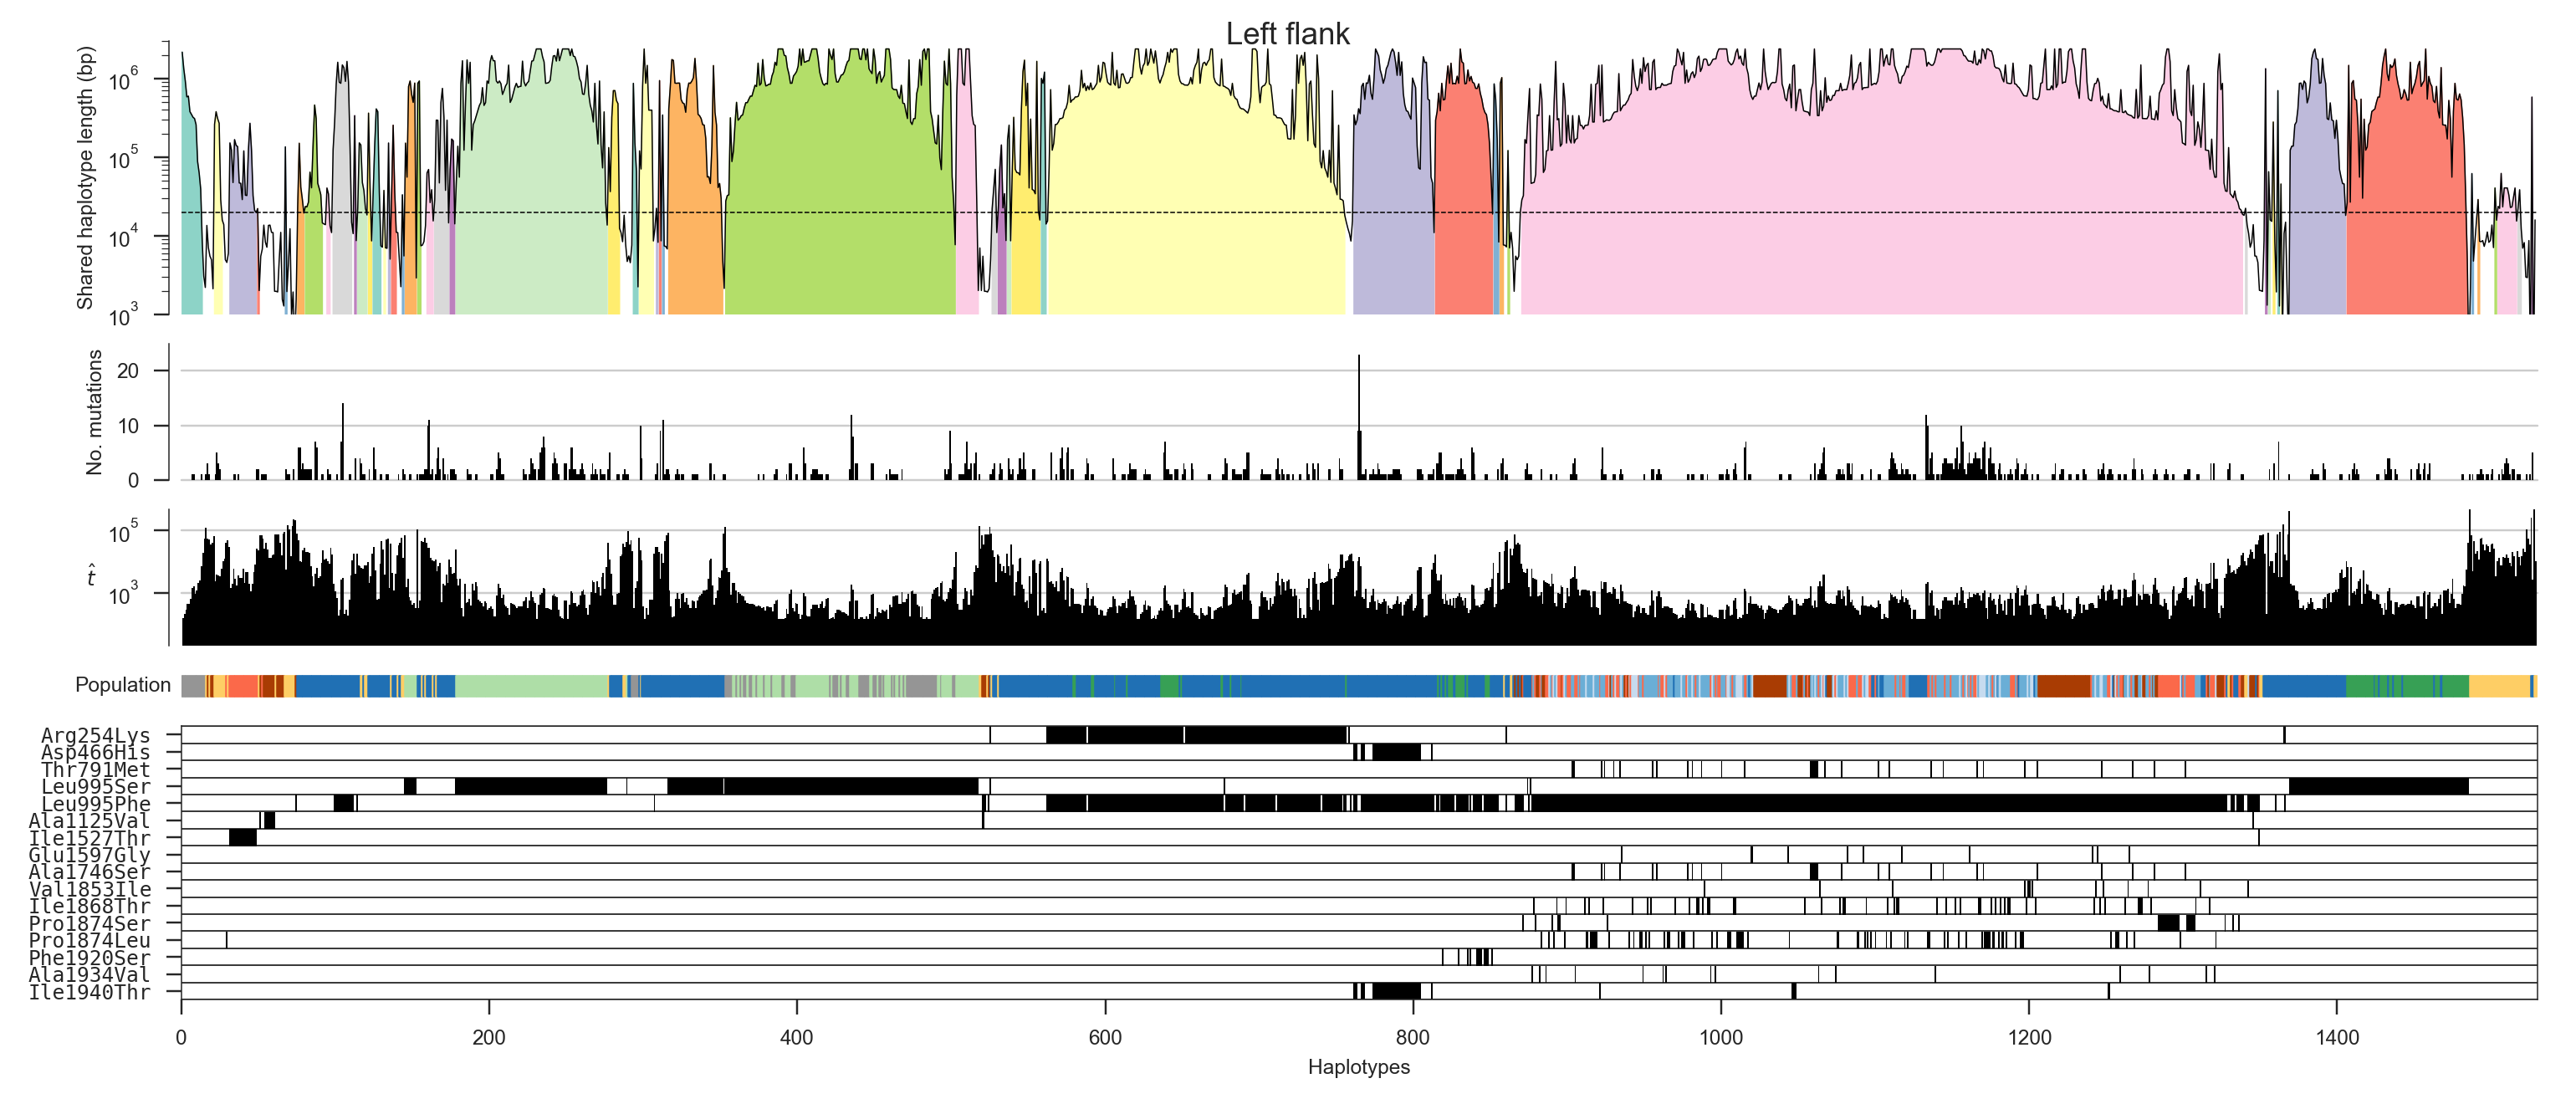

In [56]:
pops_left = df_haplotypes.population[idx_sorted_left]
pop_colors_left = [phase1_ar3.pop_colors[p] for p in pops_left]

fig = plt.figure(figsize=(14, 6))
hapclust.fig_neighbour_haplotype_sharing(nspd=nspd_left, 
                                         muts=muts_left, 
                                         nspd_accessible=nspd_left_accessible,
                                         haps_display=haps_vgsc_missense[:, idx_sorted_left],
                                         haps_display_vlbl=lbl_vgsc_missense,
                                         pop_colors=pop_colors_left,
                                         nspd_cut=2e4,
                                         nspd_ylim=(1e3, 3e6),
                                         that_ylim=(2e1, 5e5),
                                         muts_ylim=(0, 25),
                                         mu=mu_left, rr=rr_left,
                                         fig=fig)
fig.suptitle('Left flank');

In [57]:
nspl_left

array([14900, 10152,  8213, ...,  5231,     0,   212], dtype=int32)

In [58]:
# nspd_left = pos_ehh_left[-1] - np.asarray(pos_ehh_left)[(pos_ehh_left.shape[0] - 1 - nspl_left - 1).clip(min=0)]
nspd_left.min(), nspd_left.max()

(108, 2377961)

<IPython.core.display.Javascript object>


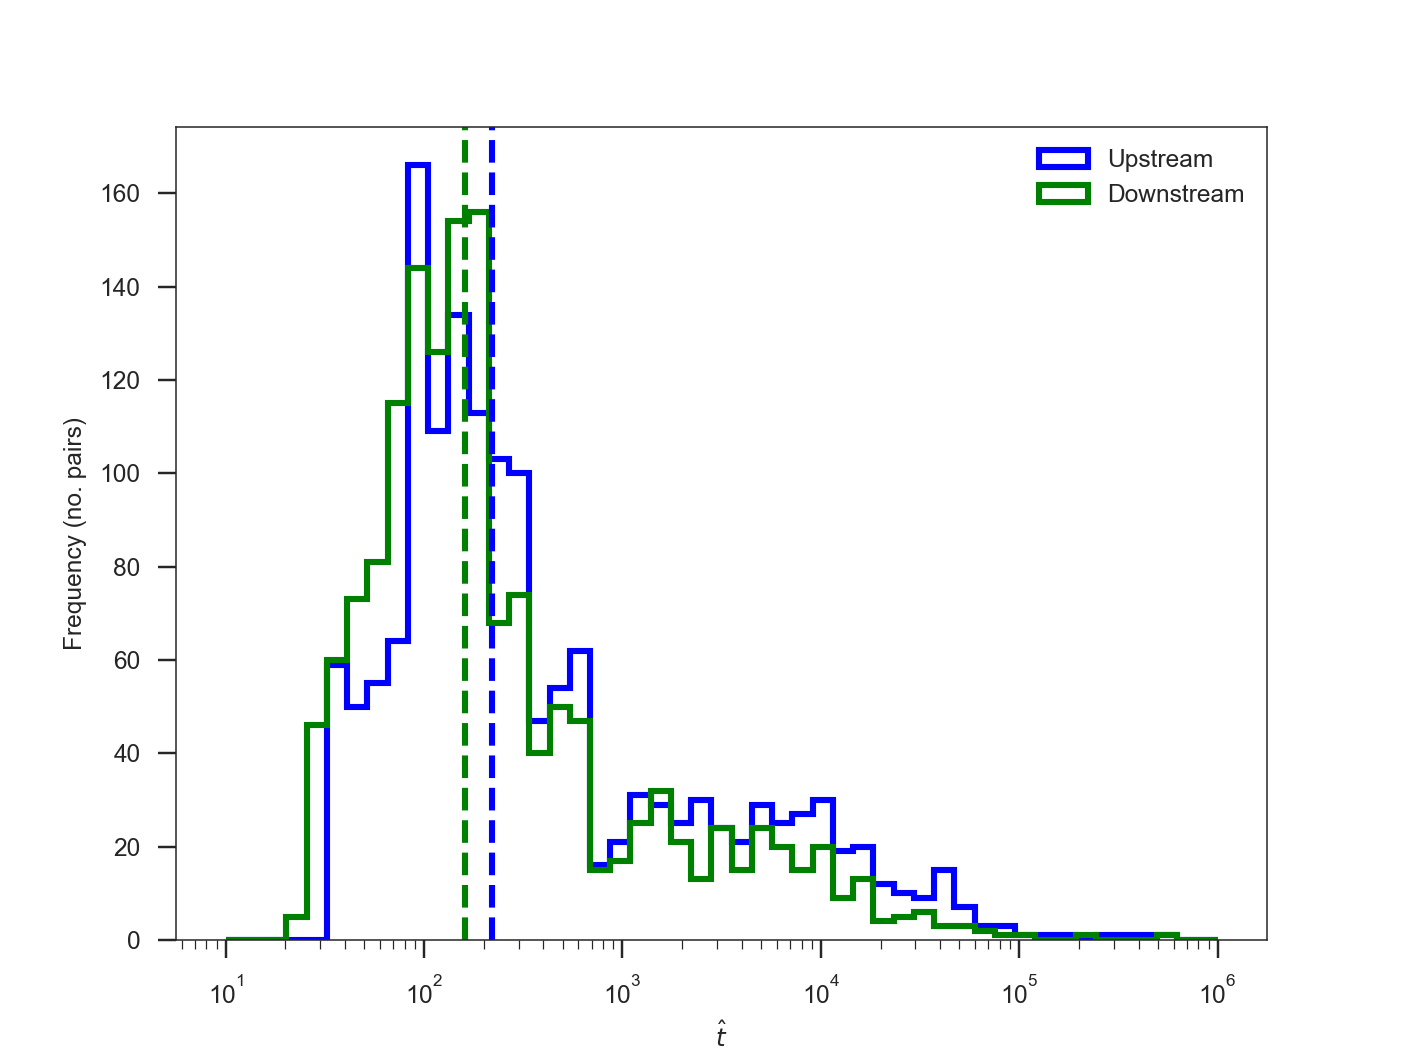

In [60]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = nspd_left
t_hat = (1 + muts_left) / (2 * (nspd_left * rr_left + nspd_left_accessible * mu_left))
ax.hist(t_hat[(nspd_left > 0)], bins=np.logspace(1, 6, 50), histtype='step', lw=2, label='Upstream', color='b')
ax.axvline(np.median(t_hat), linestyle='--', color='b', lw=2)
t_hat = (1 + muts_right) / (2 * (nspd_right * rr_right + nspd_right_accessible * mu_right))
ax.hist(t_hat[(nspd_right > 0)], bins=np.logspace(1, 6, 50), histtype='step', lw=2, label='Downstream', color='g')
ax.axvline(np.median(t_hat), linestyle='--', color='g', lw=2)
ax.set_xscale('log')
ax.set_xlabel('$\hat{t}$')
ax.set_ylabel('Frequency (no. pairs)')
ax.legend();


## Tree

In [61]:
pspl_right, pspd_right, pmuts_right = hapclust.pairwise_haplotype_sharing(
    haps_ehh_right, haps_mut_right, dist_ehh_right, dist_mut_right, jitter=False)

In [62]:
pspl_left, pspd_left, pmuts_left = hapclust.pairwise_haplotype_sharing(
    haps_ehh_left, haps_mut_left, dist_ehh_left, dist_mut_left, jitter=False)

In [63]:
pspl_right.shape, pspl_left.shape

((1169685,), (1169685,))

In [64]:
pspd_right.min(), pspd_right.max()

(45, 1437047)

In [65]:
pspd_left.min(), pspd_left.max()

(108, 2377961)

In [66]:
pspd_right_accessible = hapclust.haplotype_accessible_length(pspd_right, core_pos=core_pos, is_accessible=is_accessible, flank='right')
pspd_left_accessible = hapclust.haplotype_accessible_length(pspd_left, core_pos=core_pos, is_accessible=is_accessible, flank='left')

In [67]:
fig, ax = plt.subplots(figsize=(5, 5))
x = pspd_right
y = pspd_right_accessible
ax.plot(x, y, linestyle=' ', marker='o', markersize=4, label='Right flank')
x = pspd_left
y = pspd_left_accessible
ax.plot(x, y, linestyle=' ', marker='o', markersize=4, label='Left flank')
ax.set_xlabel('Physical length')
ax.set_ylabel('Accessible length')
lim = 0, x.max()
ax.set_xlim(*lim)
ax.set_ylim(*lim)
ax.plot(lim, lim, 'k--')
ax.legend()
ax.set_title('Pairwise shared haplotype length')
fig.tight_layout();

<IPython.core.display.Javascript object>

In [68]:
fig, ax = plt.subplots(figsize=(5, 5))
x = pspd_right
y = pspd_right_accessible
ax.plot(x, y, linestyle=' ', marker='o', markersize=4, label='Right flank')
x = pspd_left
y = pspd_left_accessible
ax.plot(x, y, linestyle=' ', marker='o', markersize=4, label='Left flank')
ax.set_xlabel('Physical length')
ax.set_ylabel('Accessible length')
lim = 0, x.max()
ax.set_xlim(*lim)
ax.set_ylim(*lim)
ax.plot(lim, lim, 'k--')
ax.legend()
ax.set_title('Pairwise shared haplotype length')
fig.tight_layout();

<IPython.core.display.Javascript object>

In [69]:
fig, ax = plt.subplots()
ax.hist(pspl_right, bins=np.logspace(1, 5, 50), histtype='step', lw=2)
ax.hist(pspl_left, bins=np.logspace(1, 5, 50), histtype='step', lw=2)
ax.set_xscale('log')
ax.set_xlabel('Shared haplotype length (no. SNPs)')
ax.set_ylabel('Frequency (no. pairs)');

<IPython.core.display.Javascript object>

In [70]:
fig, ax = plt.subplots()
ax.hist(pspd_right, bins=np.logspace(0, 6.5, 50), histtype='step', lw=2, label='Right')
ax.hist(pspd_left, bins=np.logspace(0, 6.5, 50), histtype='step', lw=2, label='Left')
ax.set_xscale('log')
ax.set_xlabel('Shared haplotype length (bp)')
ax.set_ylabel('Frequency (no. pairs)')
ax.legend();

<IPython.core.display.Javascript object>

In [71]:
fig, ax = plt.subplots()
ax.hist(pspd_right, bins=np.logspace(0, 6.5, 50), histtype='step', lw=2, label='Right')
ax.hist(pspd_left, bins=np.logspace(0, 6.5, 50), histtype='step', lw=2, label='Left')
ax.set_xscale('log')
ax.set_xlabel('Shared haplotype length (bp)')
ax.set_ylabel('Frequency (no. pairs)')
ax.legend();

<IPython.core.display.Javascript object>

In [72]:
fig, ax = plt.subplots()
ax.hist(pspd_right_accessible, bins=np.logspace(0, 6.5, 50), histtype='step', lw=2, label='Right')
ax.hist(pspd_left_accessible, bins=np.logspace(0, 6.5, 50), histtype='step', lw=2, label='Left')
ax.set_xscale('log')
ax.set_xlabel('Shared haplotype length - accessible (bp)')
ax.set_ylabel('Frequency (no. pairs)')
ax.legend();

<IPython.core.display.Javascript object>

In [73]:
fig, ax = plt.subplots()
ax.hist(pspd_right_accessible, bins=np.logspace(0, 6.5, 50), histtype='step', lw=2, label='Right')
ax.hist(pspd_left_accessible, bins=np.logspace(0, 6.5, 50), histtype='step', lw=2, label='Left')
ax.set_xscale('log')
ax.set_xlabel('Shared haplotype length - accessible (bp)')
ax.set_ylabel('Frequency (no. pairs)')
ax.legend();

<IPython.core.display.Javascript object>

In [74]:
import statsmodels.formula.api as sfa

Check recombination rate on left versus right flank.

In [75]:
pspd_left.min(), pspd_right.min()

(108, 45)

<IPython.core.display.Javascript object>


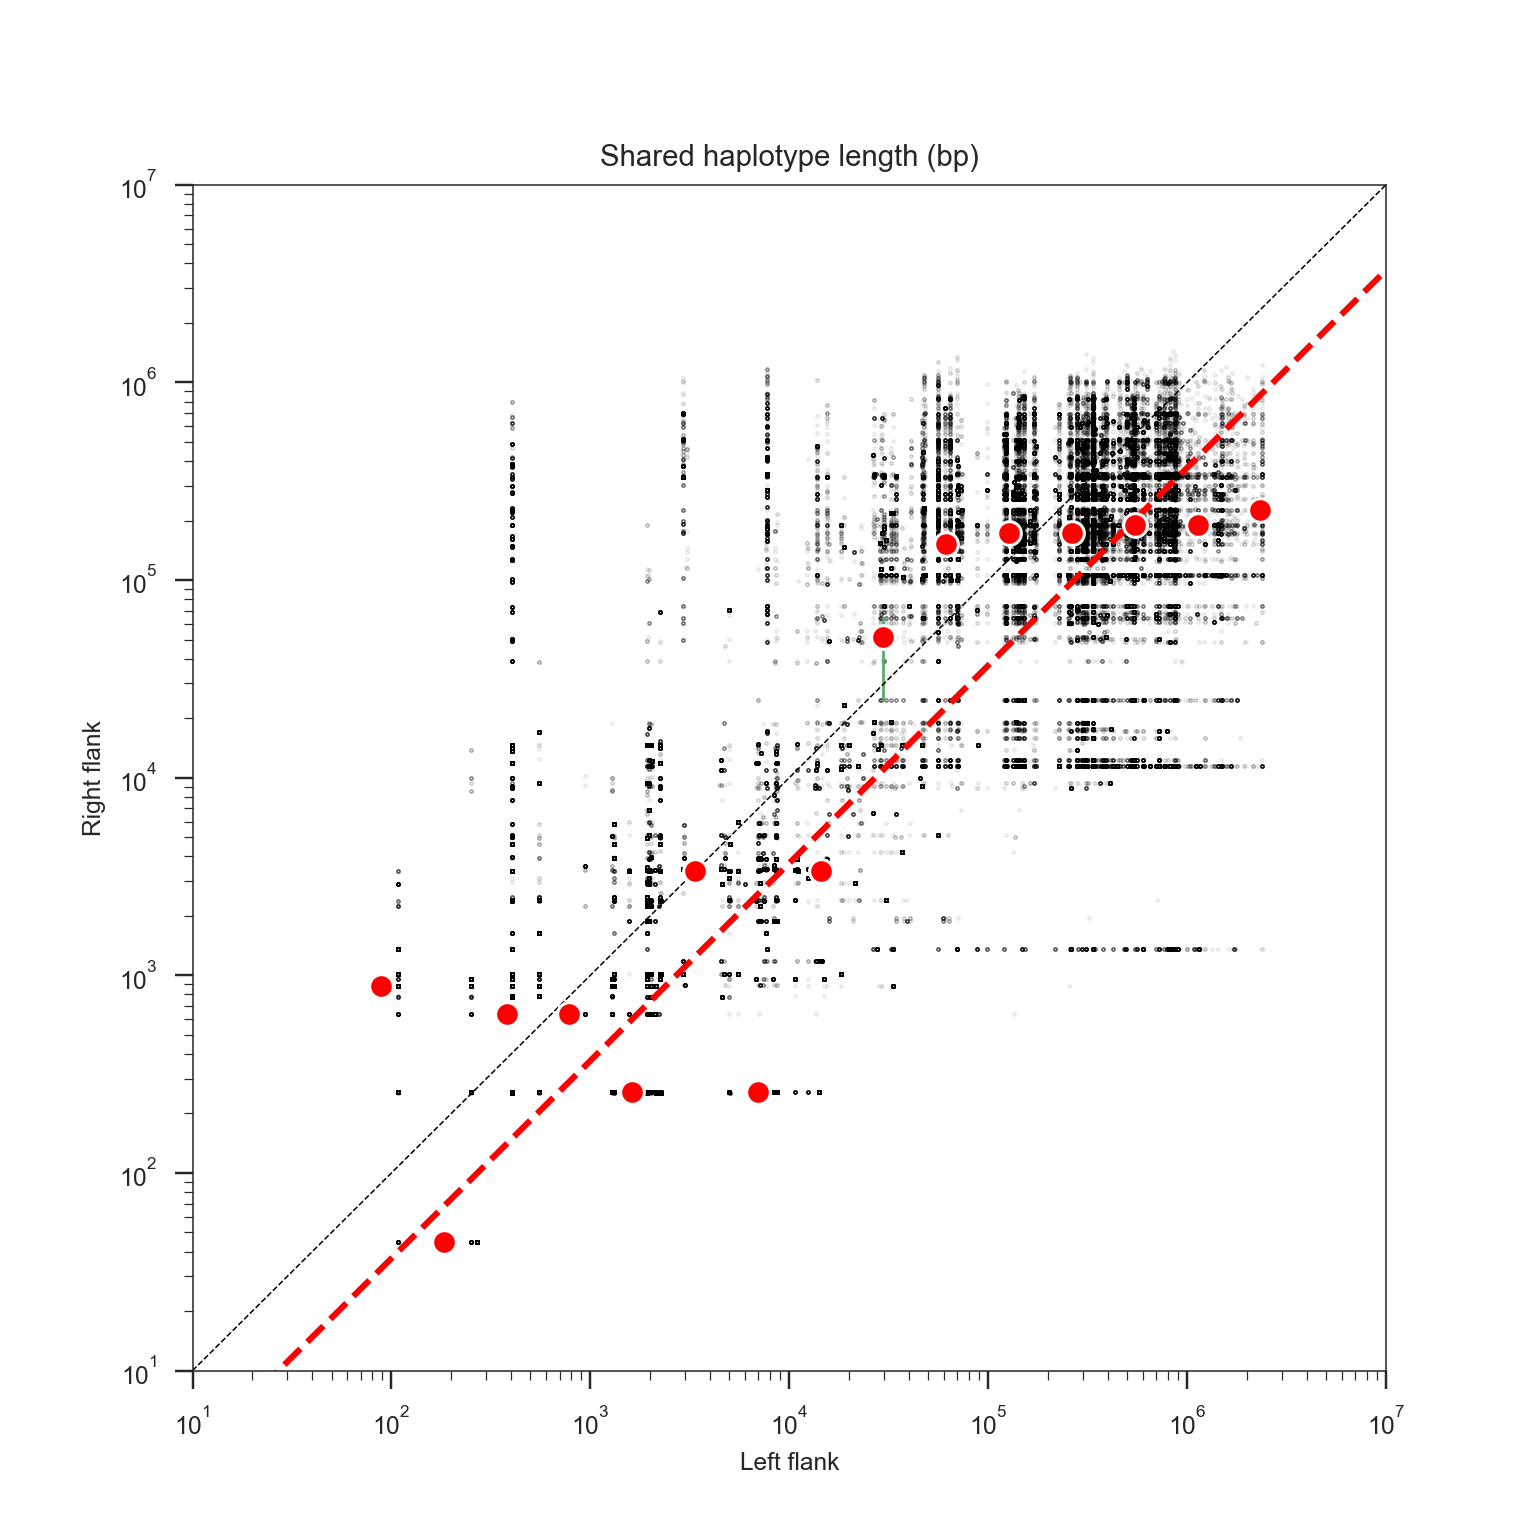

x    0.369611
dtype: float64

In [80]:
x = pspd_left
y = pspd_right

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(x, y, marker='o', markersize=1, mfc='none', mec='k', linestyle=' ', alpha=.1)
lim = 1e1, 1e7

df = pandas.DataFrame({'x': x, 'y': y})
r = sfa.ols('y ~ x + 0', data=df).fit()
ax.plot(lim, [l * r.params['x'] for l in lim], linestyle='--', color='r', lw=2)
sns.regplot(x, y, ax=ax, n_boot=10, x_estimator=np.median, x_bins=np.logspace(np.log10(lim[0]), np.log10(lim[1]), 20), fit_reg=False, 
            scatter_kws=dict(alpha=1, zorder=20, facecolor='r', edgecolor='w', linewidth=1, s=60));

ax.set_xlim(*lim)
ax.set_ylim(*lim)
ax.plot(lim, lim, 'k--')
ax.set_xlabel('Left flank')
ax.set_ylabel('Right flank')
ax.set_title('Shared haplotype length (bp)')
ax.set_xscale('log')
ax.set_yscale('log')
r.params

<IPython.core.display.Javascript object>


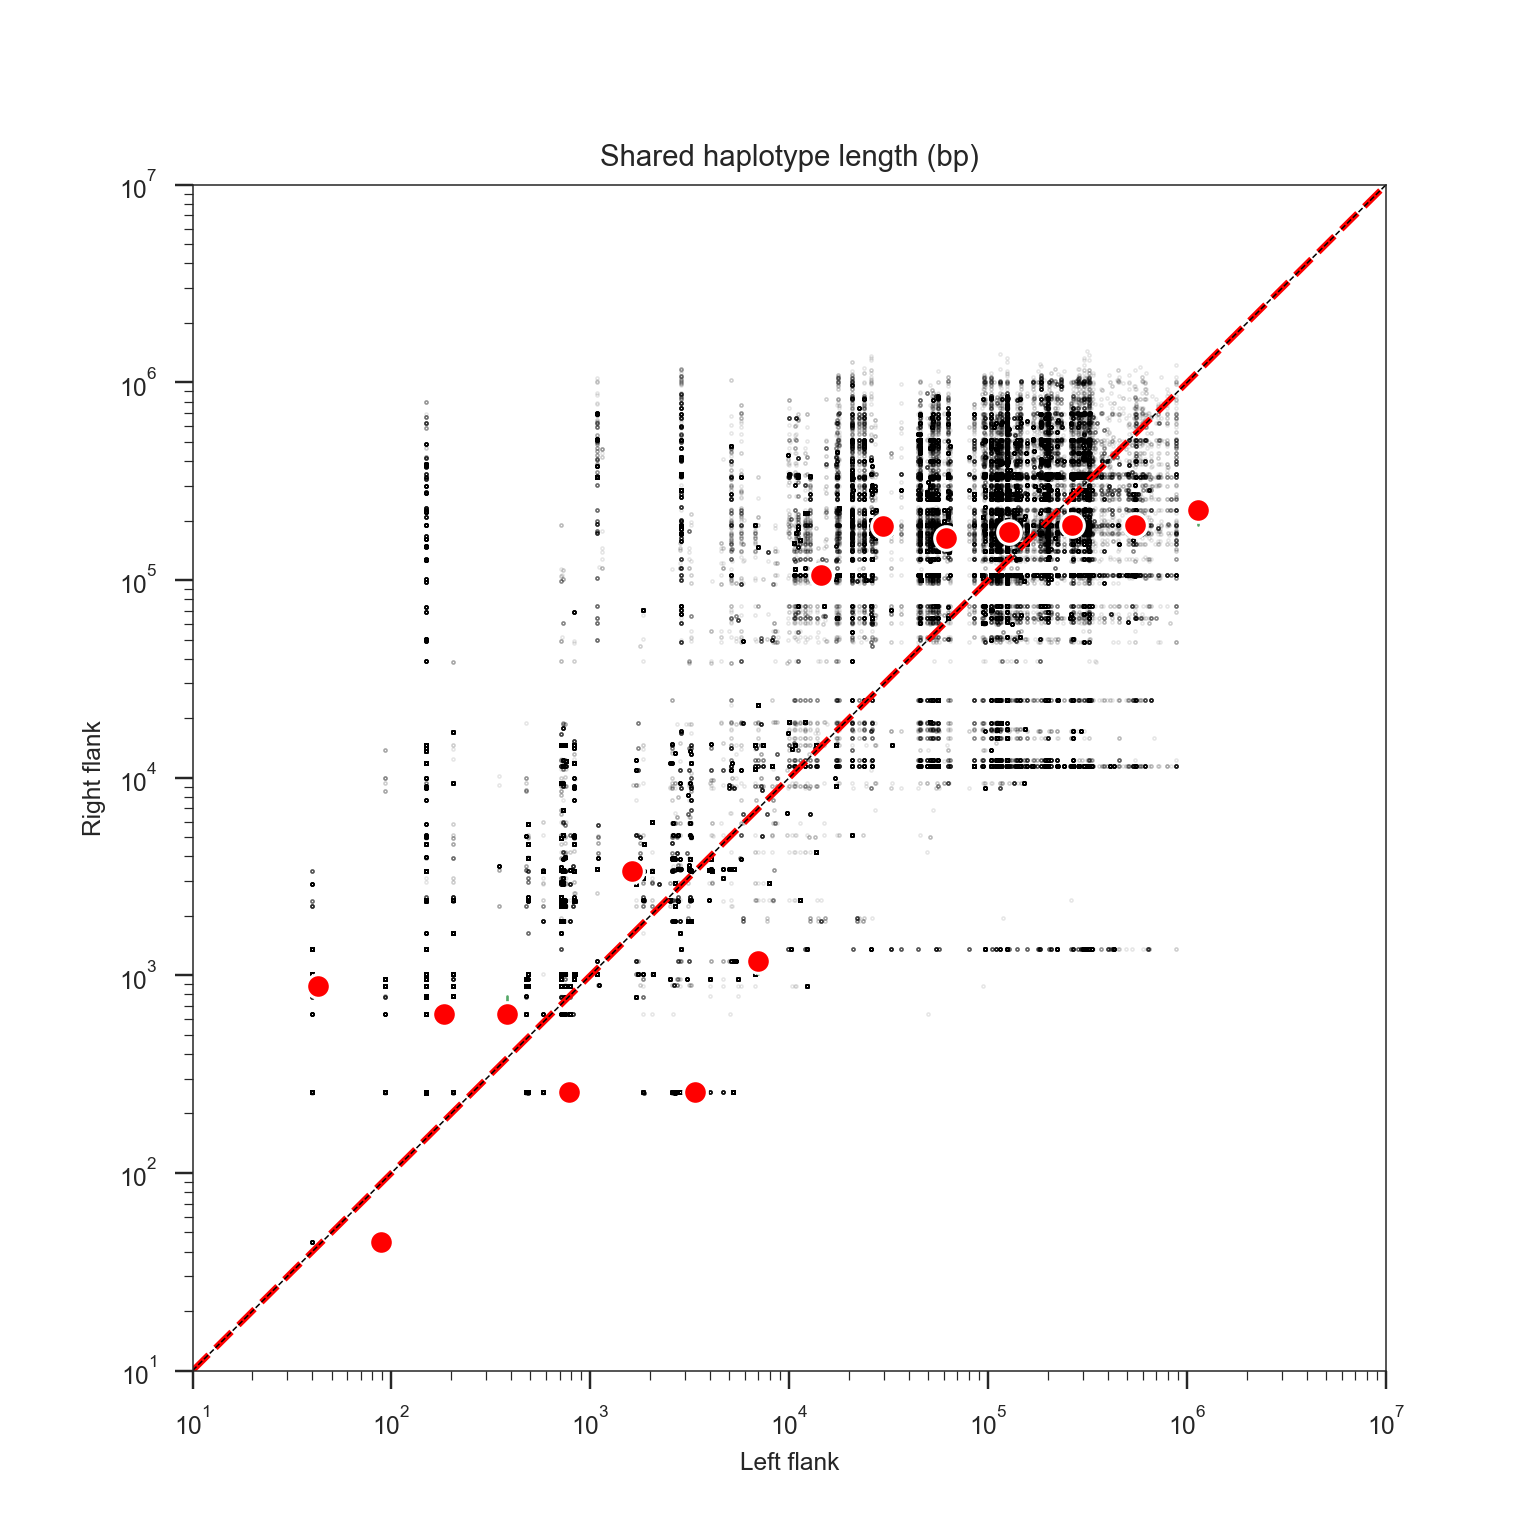

x    0.99895
dtype: float64

In [83]:
x = pspd_left * rr_left / rr_right
y = pspd_right

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(x, y, marker='o', markersize=1, mfc='none', mec='k', linestyle=' ', alpha=.1)
lim = 1e1, 1e7

df = pandas.DataFrame({'x': x, 'y': y})
r = sfa.ols('y ~ x + 0', data=df).fit()
ax.plot(lim, [l * r.params['x'] for l in lim], linestyle='--', color='r', lw=2)
sns.regplot(x, y, ax=ax, n_boot=10, x_estimator=np.median, x_bins=np.logspace(np.log10(lim[0]), np.log10(lim[1]), 20), fit_reg=False, 
            scatter_kws=dict(alpha=1, zorder=20, facecolor='r', edgecolor='w', linewidth=1, s=60));

ax.set_xlim(*lim)
ax.set_ylim(*lim)
ax.plot(lim, lim, 'k--')
ax.set_xlabel('Left flank')
ax.set_ylabel('Right flank')
ax.set_title('Shared haplotype length (bp)')
ax.set_xscale('log')
ax.set_yscale('log')
r.params

In [84]:
phase1_ar3.tbl_chromatin

+---------+-------+----------+----------+
| name    | chrom | start    | stop     |
+=========+=======+==========+==========+
| 'CHX'   | 'X'   | 20009764 | 24393108 |
+---------+-------+----------+----------+
| 'CH2R'  | '2R'  | 58984778 | 61545105 |
+---------+-------+----------+----------+
| 'CH2L'  | '2L'  |        1 |  2431617 |
+---------+-------+----------+----------+
| 'PEU2L' | '2L'  |  2487770 |  5042389 |
+---------+-------+----------+----------+
| 'IH2L'  | '2L'  |  5078962 |  5788875 |
+---------+-------+----------+----------+
...

Check mutation rate on left versus right flank.

In [85]:
pspd_left.min(), pspd_right.min()

(108, 45)

<IPython.core.display.Javascript object>


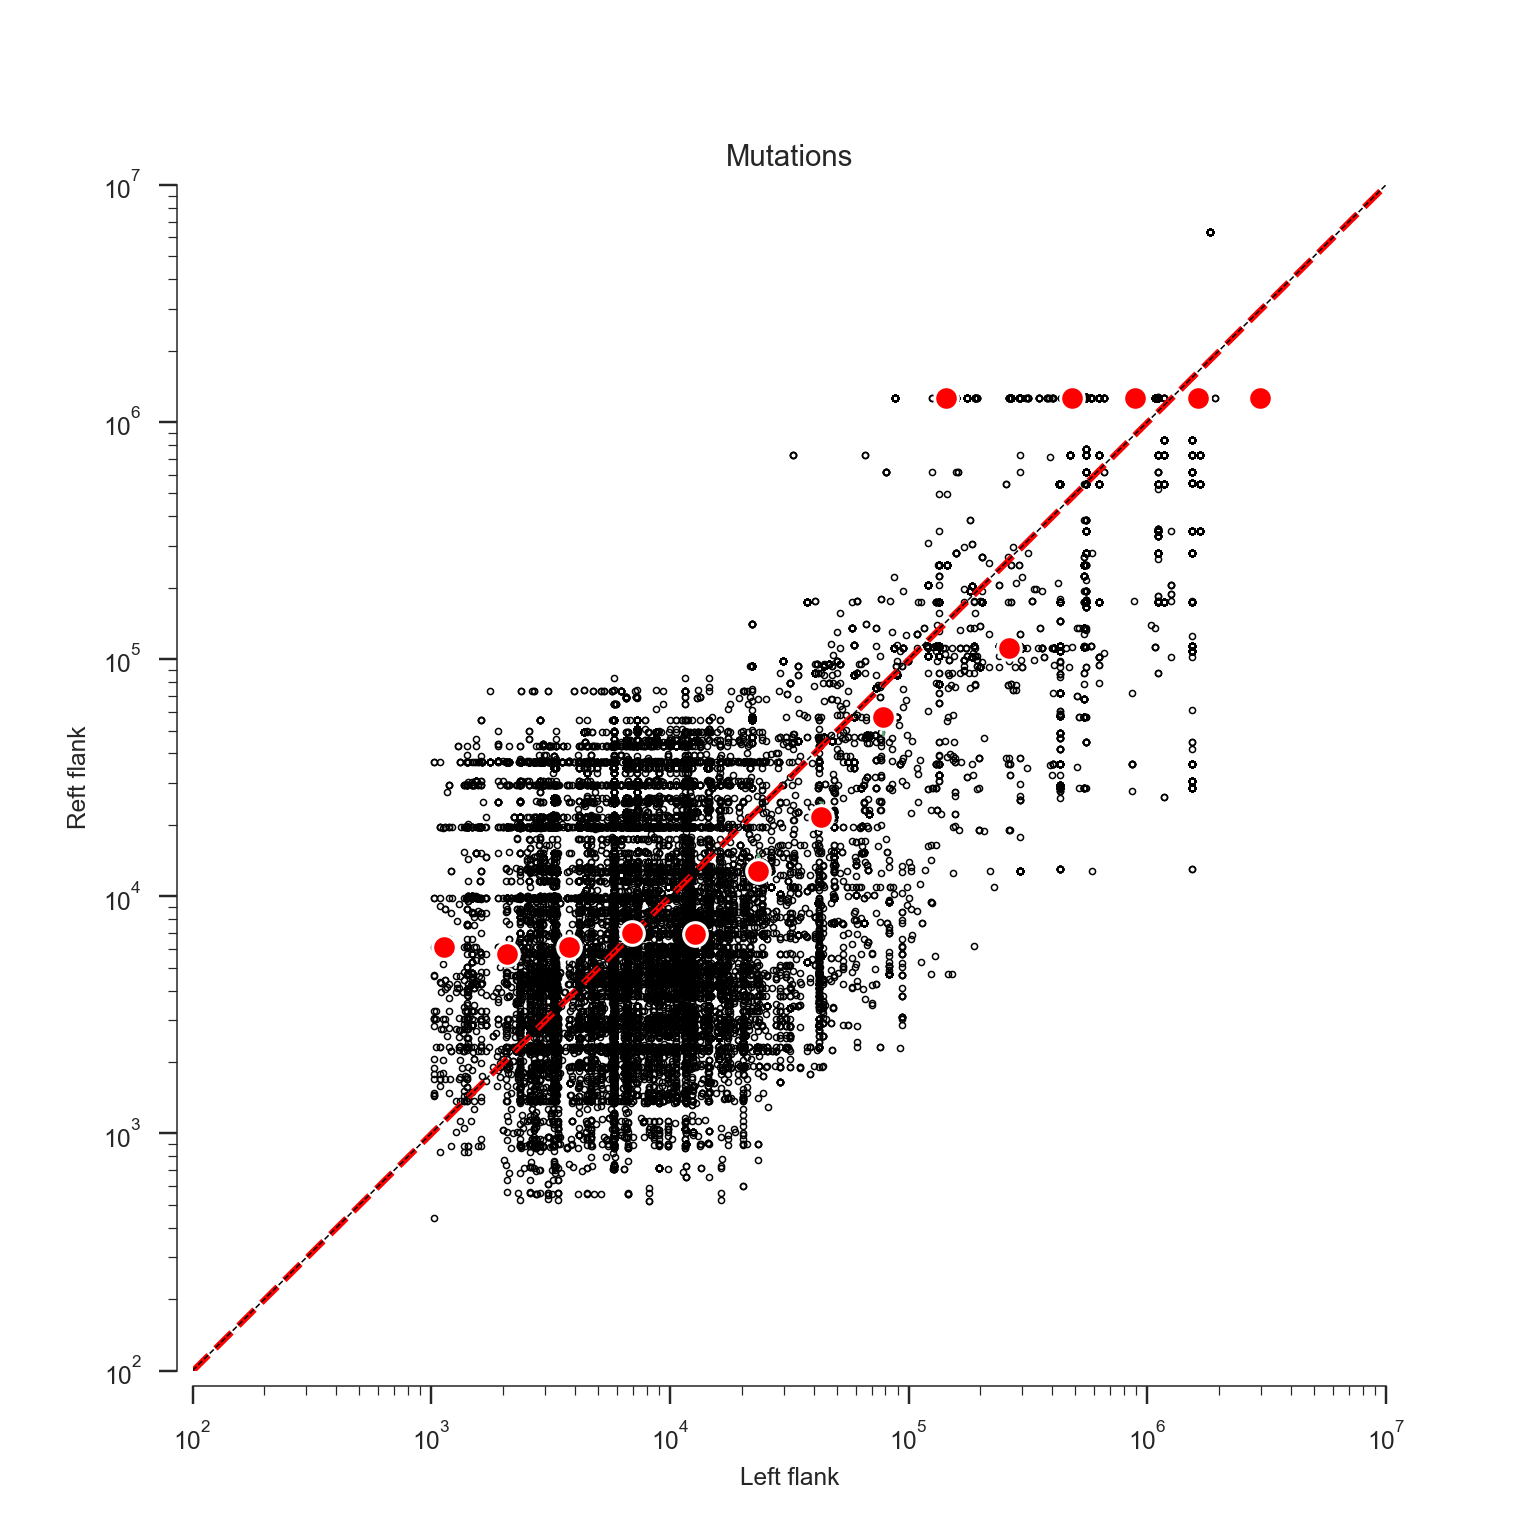

x    0.993815
dtype: float64

In [86]:
x = pmuts_left / (mu_left * pspd_left_accessible)
y = pmuts_right / (mu_right * pspd_right_accessible)
tst = (x > 0) & (y > 0)
x = x[tst]
y = y[tst]

lim = 1e2, 1e7
fig, ax = plt.subplots(figsize=(7, 7))
sns.despine(ax=ax, offset=5)
ax.plot(x, y, marker='o', markersize=2, mfc='none', mec='k', linestyle=' ')

df = pandas.DataFrame({'x': x, 'y': y})
r = sfa.ols('y ~ x + 0', data=df).fit()
ax.plot(lim, [l * r.params['x'] for l in lim], linestyle='--', color='r', lw=2)
sns.regplot(x, y, ax=ax, n_boot=10, x_estimator=np.median, x_bins=np.logspace(np.log10(lim[0]), np.log10(lim[1]), 20), fit_reg=False, 
            scatter_kws=dict(alpha=1, zorder=20, facecolor='r', edgecolor='w', linewidth=1, s=60));


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(*lim)
ax.set_ylim(*lim)
ax.plot(lim, lim, linestyle='--', color='k')
ax.set_title('Mutations')
ax.set_xlabel('Left flank')
ax.set_ylabel('Reft flank')
r.params
# ax.plot(x, y, marker='o', linestyle=' ', markersize=2, mfc='none');

<IPython.core.display.Javascript object>


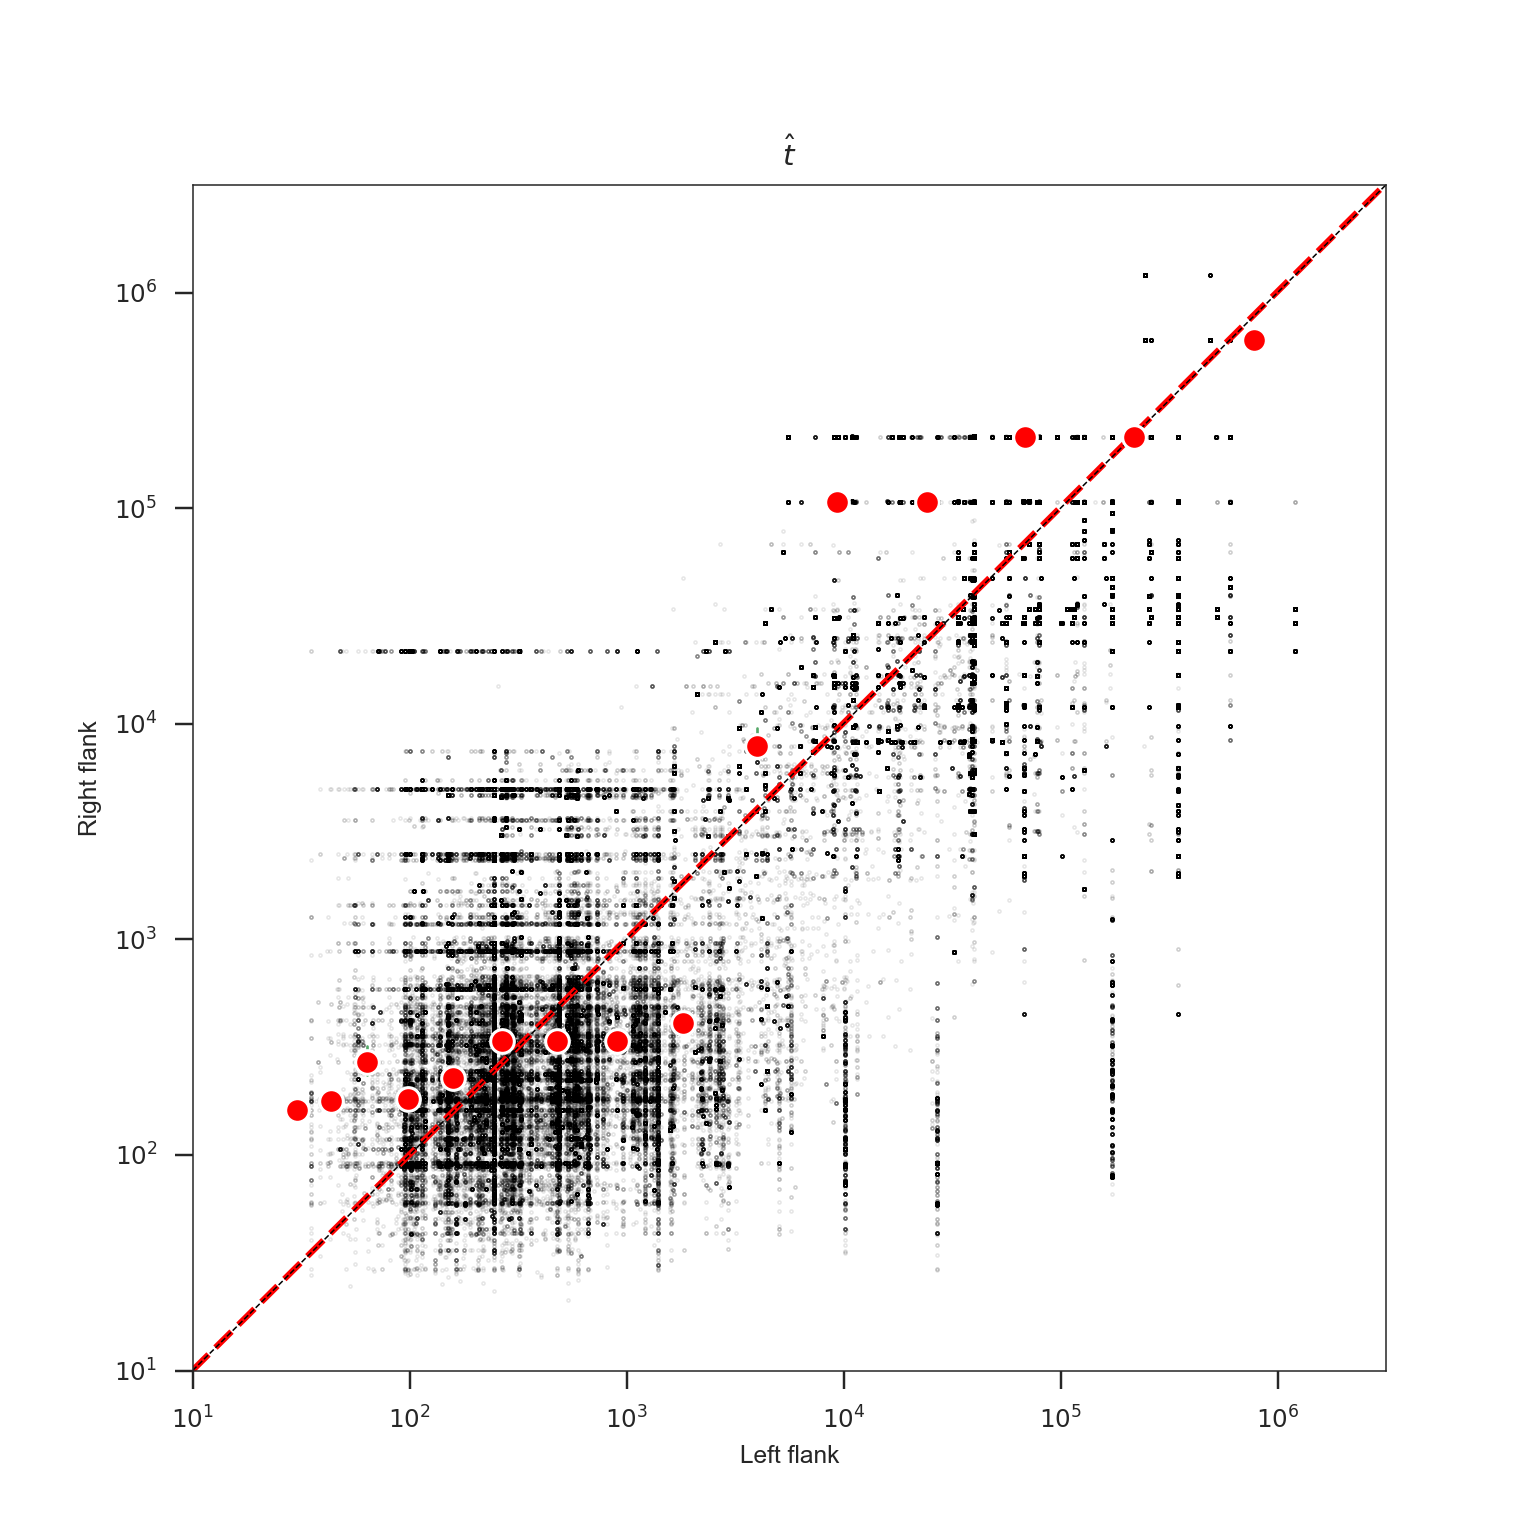

x    1.00086
dtype: float64

In [87]:
pt_hat_left = (1 + pmuts_left) / (2 * (pspd_left * rr_left + pspd_left_accessible * mu_left))
pt_hat_right = (1 + pmuts_right) / (2 * (pspd_right * rr_right + pspd_right_accessible * mu_right))
x = np.log10(pt_hat_left)
y = np.log10(pt_hat_right)

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(x, y, marker='o', markersize=1, mfc='none', mec='k', linestyle=' ', alpha=.1)
lim = 1, 6.5

df = pandas.DataFrame({'x': x, 'y': y})
r = sfa.ols('y ~ x + 0', data=df).fit()
ax.plot(lim, [l * r.params['x'] for l in lim], linestyle='--', color='r', lw=2)
sns.regplot(x, y, ax=ax, n_boot=10, x_estimator=np.median, x_bins=np.logspace(np.log10(lim[0]), np.log10(lim[1]), 20), fit_reg=False, 
            scatter_kws=dict(alpha=1, zorder=20, facecolor='r', edgecolor='w', linewidth=1, s=60));

ax.set_xlim(*lim)
ax.set_ylim(*lim)
ax.plot(lim, lim, 'k--')
ax.set_xlabel('Left flank')
ax.set_ylabel('Right flank')
ax.set_title('$\hat{t}$')
ticks = np.arange(lim[0], int(lim[1]) + 1)
ticklabels = ['$10^{%s}$' % t for t in ticks]
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.set_yticks(ticks)
ax.set_yticklabels(ticklabels)
r.params

In [88]:
pspl_right.max(), nspl_right.max()

(76267, 76267)

In [89]:
pspd_right.max(), nspd_right.max()

(1437047, 1437047)

In [90]:
pspl_left.max(), nspl_left.max()

(15754, 15754)

In [91]:
pspd_left.max(), nspd_left.max()

(2377961, 2377961)

In [92]:
pmuts_right.shape, pmuts_left.shape

((1169685,), (1169685,))

In [93]:
muts_right.max(), muts_left.max()

(14, 23)

In [94]:
pmuts_right.max(), pmuts_left.max()

(16, 23)

In [95]:
np.bincount(pmuts_right)

array([482069, 638359,  37050,   8834,   2200,    735,    273,    119,
           23,     11,      1,      2,      1,      2,      4,      1,
            1])

In [96]:
np.bincount(pmuts_left)

array([639336, 509488,  14927,   3572,   1236,    552,    283,     89,
           43,     59,     32,     18,     13,     28,      7,      1,
            0,      0,      0,      0,      0,      0,      0,      1])

<IPython.core.display.Javascript object>


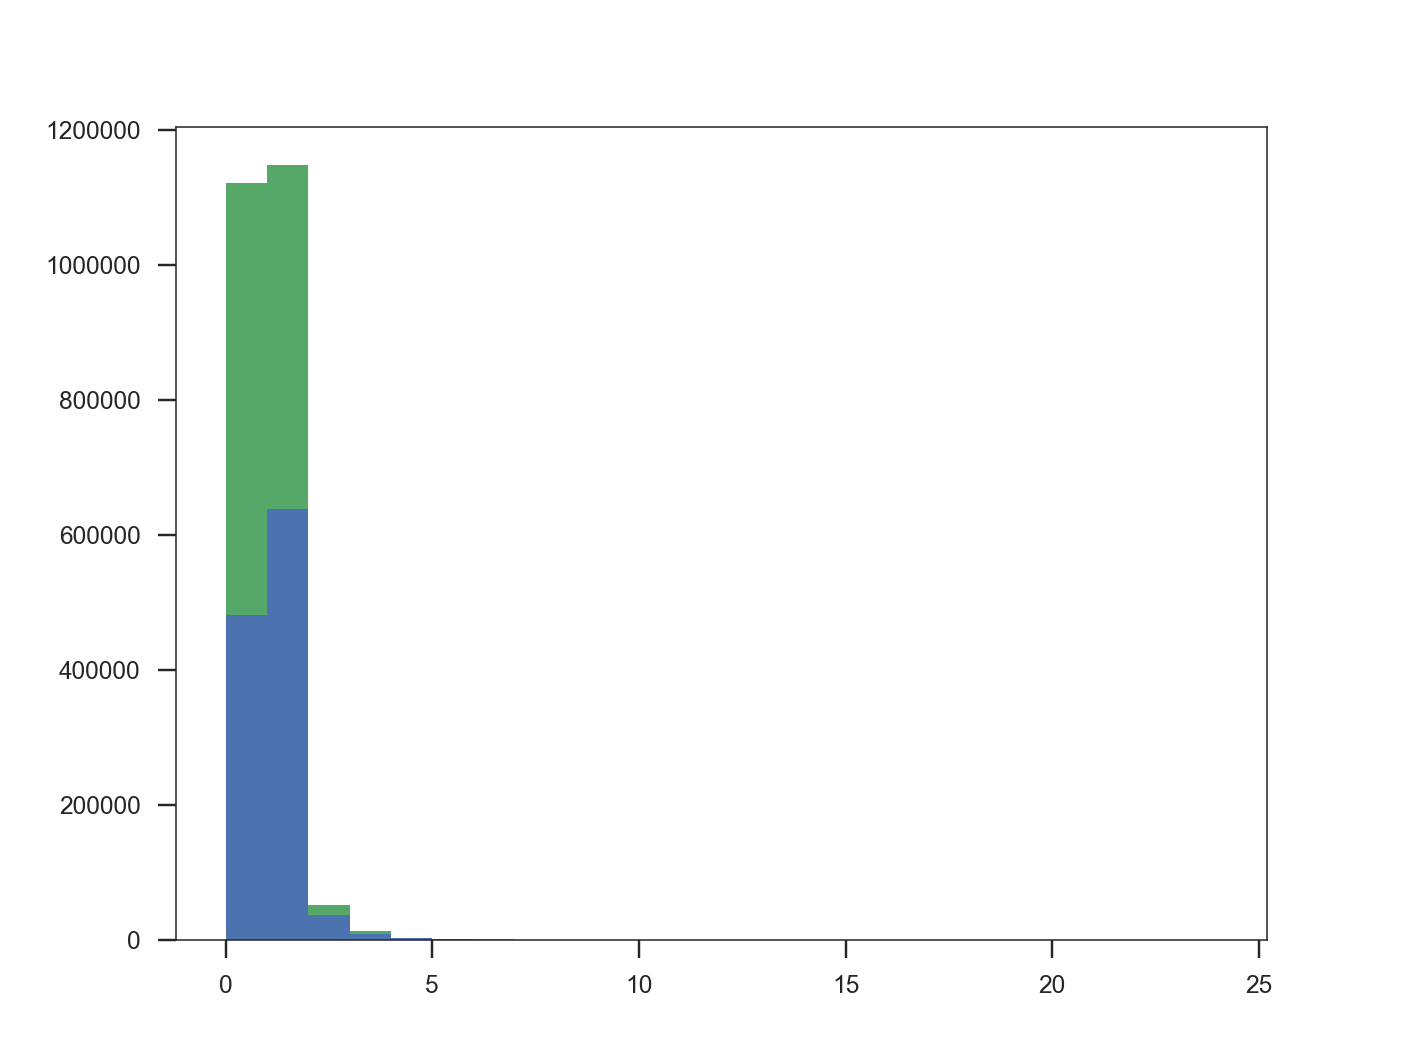

In [97]:
fig, ax = plt.subplots()
ax.hist([pmuts_right, pmuts_left], stacked=True, bins=np.arange(25));

<IPython.core.display.Javascript object>


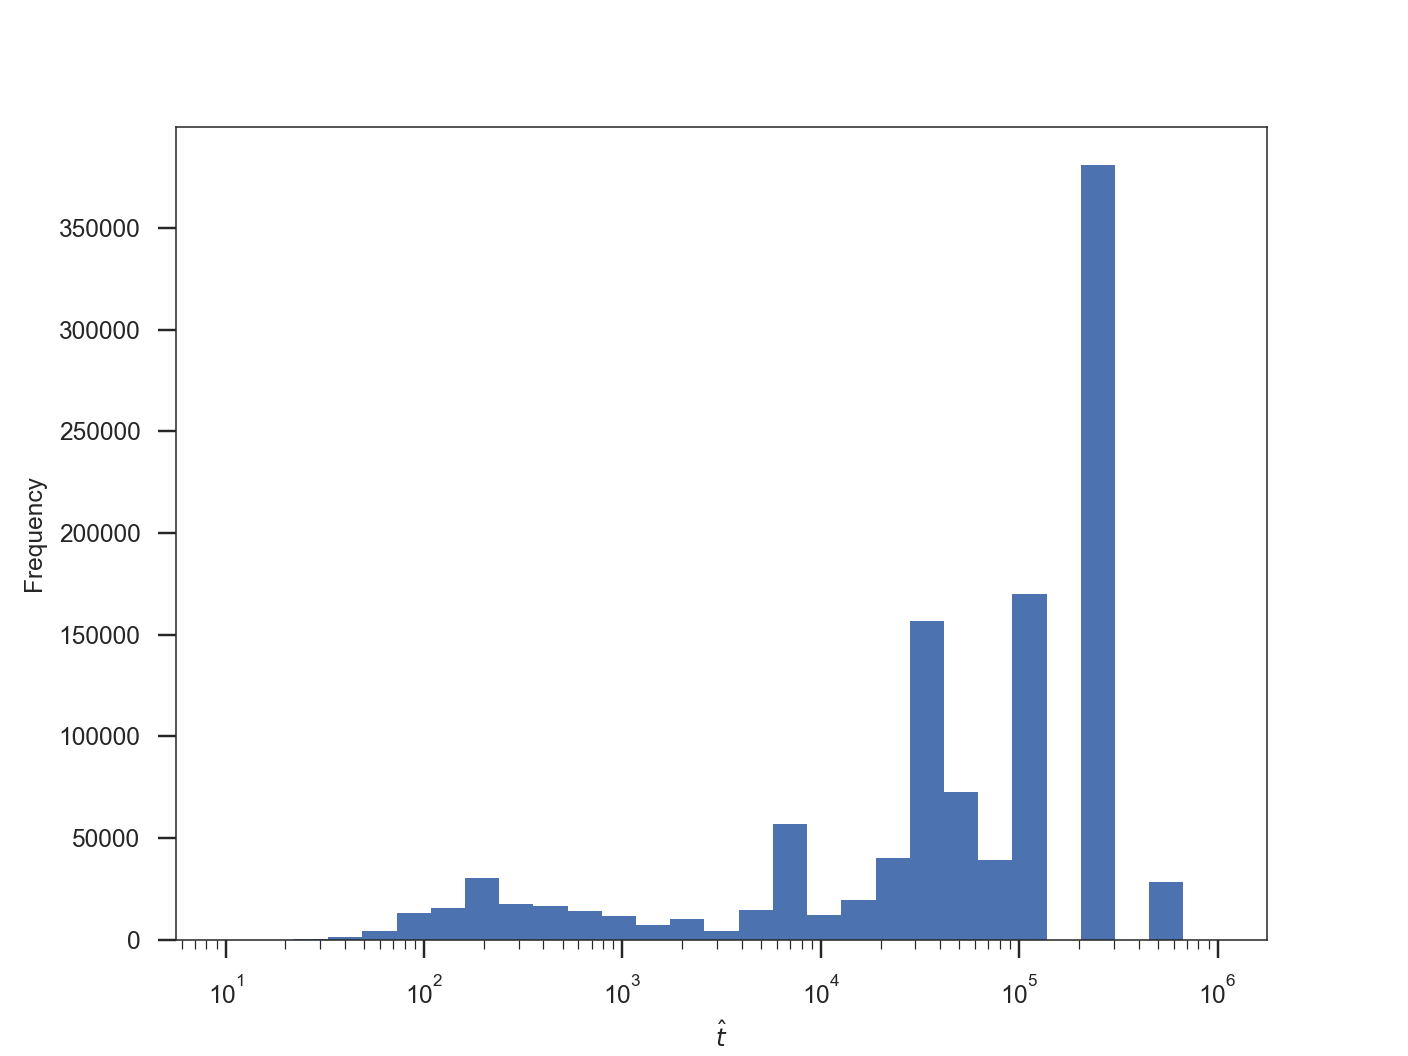

In [100]:
pt_hat_right = (1 + pmuts_right) / (2 * (pspd_right * rr_right + pspd_right_accessible * mu_right))
fig, ax = plt.subplots()
ax.hist(pt_hat_right, bins=np.logspace(1, 6, 30))
ax.set_xscale('log')
ax.set_xlabel('$\hat{t}$')
ax.set_ylabel('Frequency');

<IPython.core.display.Javascript object>


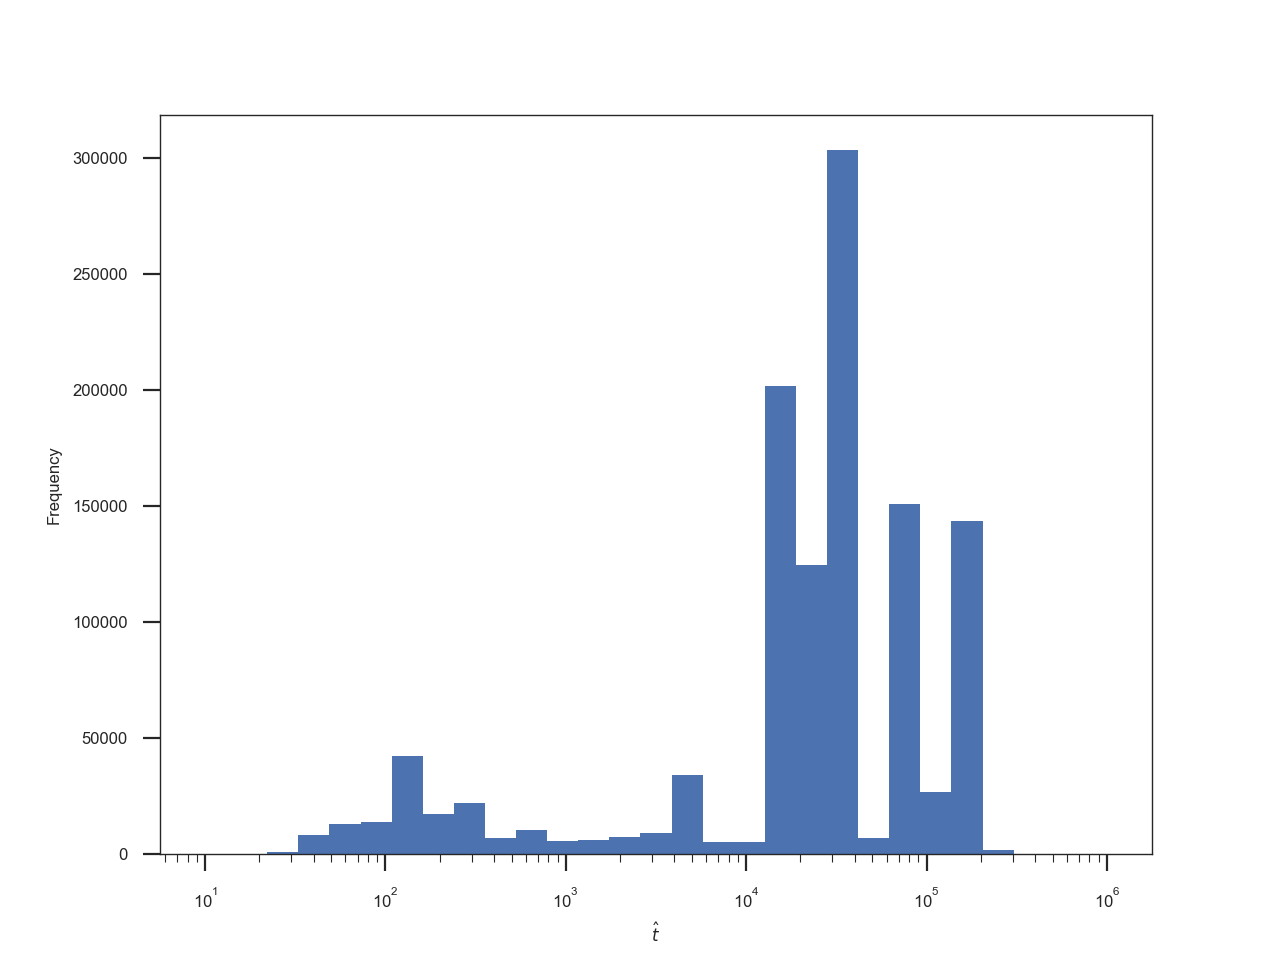

In [173]:
pt_hat_left = (1 + pmuts_left) / (2 * (pspd_left * rr_left + pspd_left_accessible * mu_left))
fig, ax = plt.subplots()
ax.hist(pt_hat_left, bins=np.logspace(1, 6, 30))
ax.set_xscale('log')
ax.set_xlabel('$\hat{t}$')
ax.set_ylabel('Frequency');

<IPython.core.display.Javascript object>


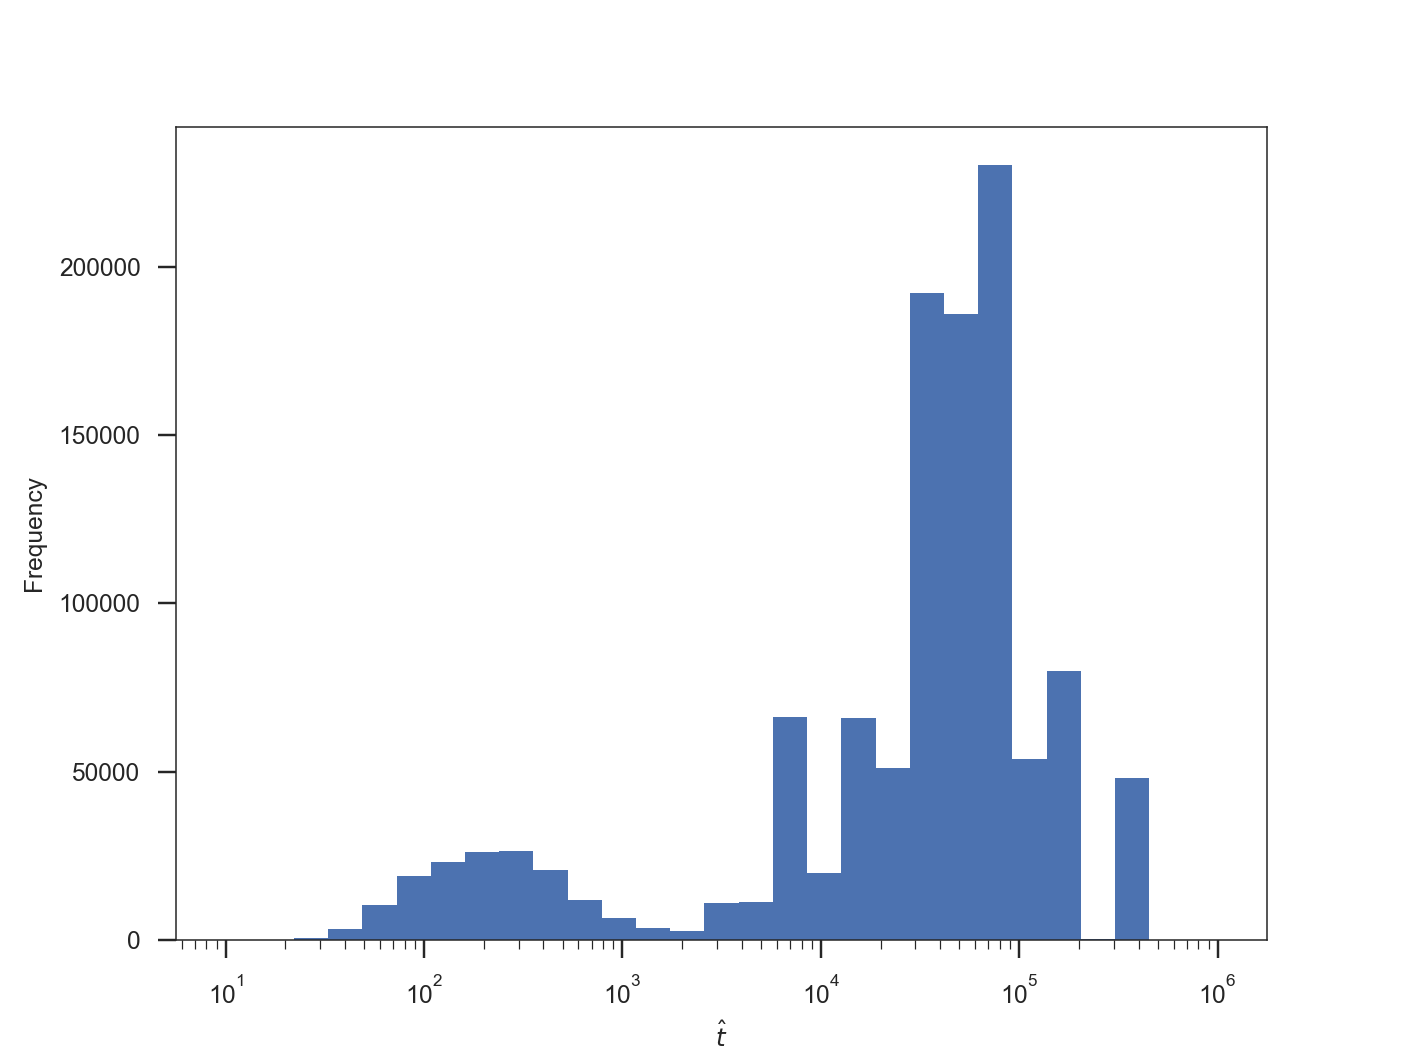

In [101]:
pspd_both = pspd_left + pspd_right
pmuts_both = pmuts_left + pmuts_right
psgl_both = pspd_left * rr_left + pspd_right * rr_right
psml_both = pspd_left_accessible * mu_left + pspd_right_accessible * mu_right

pt_hat_both = (1 + pmuts_both) / (2 * (psgl_both + psml_both))
fig, ax = plt.subplots()
ax.hist(pt_hat_both, bins=np.logspace(1, 6, 30))
ax.set_xscale('log')
ax.set_xlabel('$\hat{t}$')
ax.set_ylabel('Frequency');

In [102]:
def plot_dendrogram(dist, cut_height=1e3, yscale='log', ylim=(10, 1e6), linkage_method='average',
                    n_clusters=14):
    z = scipy.cluster.hierarchy.linkage(dist, method=linkage_method)

    fig = plt.figure(figsize=(16, 8))
    gs = mpl.gridspec.GridSpec(nrows=3, ncols=1, height_ratios=[6, .5, 4], hspace=0)

    ax = fig.add_subplot(gs[0])
    sns.despine(ax=ax, offset=3, bottom=True, top=False)
    r = scipy.cluster.hierarchy.dendrogram(
        z, no_labels=True, count_sort=True, 
        color_threshold=0, 
        above_threshold_color='k',
        ax=ax)
    ax.set_ylim(*ylim)
    ax.set_yscale(yscale)
    # ax.set_ylim(bottom=-1000)
    xmin, xmax = ax.xaxis.get_data_interval()
    xticklabels = np.array(list(range(0, len(df_haplotypes), 200)) + [len(df_haplotypes)])
    xticks = xticklabels / len(df_haplotypes)
    xticks = (xticks * (xmax - xmin)) + xmin
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel('Haplotypes')
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('$\hat{t}$', rotation=0, ha='right')

    cluster_palette = sns.color_palette('Set3', n_colors=12)
    if cut_height:
        ax.axhline(cut_height, linestyle='--', color='k')
        # find clusters
        f = scipy.cluster.hierarchy.fcluster(z, cut_height, criterion='distance')
        # compute cluster sizes
        fsz = np.bincount(f)
        # sort largest first
        fsort = np.argsort(fsz)[::-1]
        # take largest n
        fsort = fsort[:n_clusters]
        # get haplotype indices for each cluster
        clusters = [set(np.nonzero(f == i)[0]) for i in fsort]
        clusters_leaves = [sorted([r['leaves'].index(i) for i in cluster])
                           for cluster in clusters]
        ixs = np.argsort([min(cl) for cl in clusters_leaves])
        clusters = [clusters[i] for i in ixs]
        clusters_leaves = [clusters_leaves[i] for i in ixs]
        for i, cluster_leaves in enumerate(clusters_leaves):
            color = cluster_palette[i % len(cluster_palette)]
            x1, x2 = min(cluster_leaves), max(cluster_leaves)
            ax.axvline(x1*10, color='k', linestyle='--')
            ax.axvline(x2*10, color='k', linestyle='--')
            ax.axvspan(x1*10, x2*10, color=color, zorder=-20, alpha=.5)
        
    ax = fig.add_subplot(gs[1])
    sns.despine(ax=ax, left=True, bottom=True)
    pops = df_haplotypes.population[r['leaves']]
    pop_colors = [phase1_ar3.pop_colors[p] for p in pops]
    ax.broken_barh([(i, 1) for i in range(len(df_haplotypes))], yrange=(0, 1), color=pop_colors)
    ax.set_xlim(0, len(df_haplotypes))
    ax.set_yticks([])
    ax.set_ylabel('Population', rotation=0, ha='right', va='center')
    ax.set_xticks([])

    ax = fig.add_subplot(gs[2])
    hapclust.plot_haplotypes(ax, haps_vgsc_missense[:, r['leaves']], lbl_vgsc_missense)
    ax.set_xlim(0, len(df_haplotypes))
    ax.set_xlabel('Haplotypes')

    gs.tight_layout(fig, h_pad=0)
    return clusters

<IPython.core.display.Javascript object>


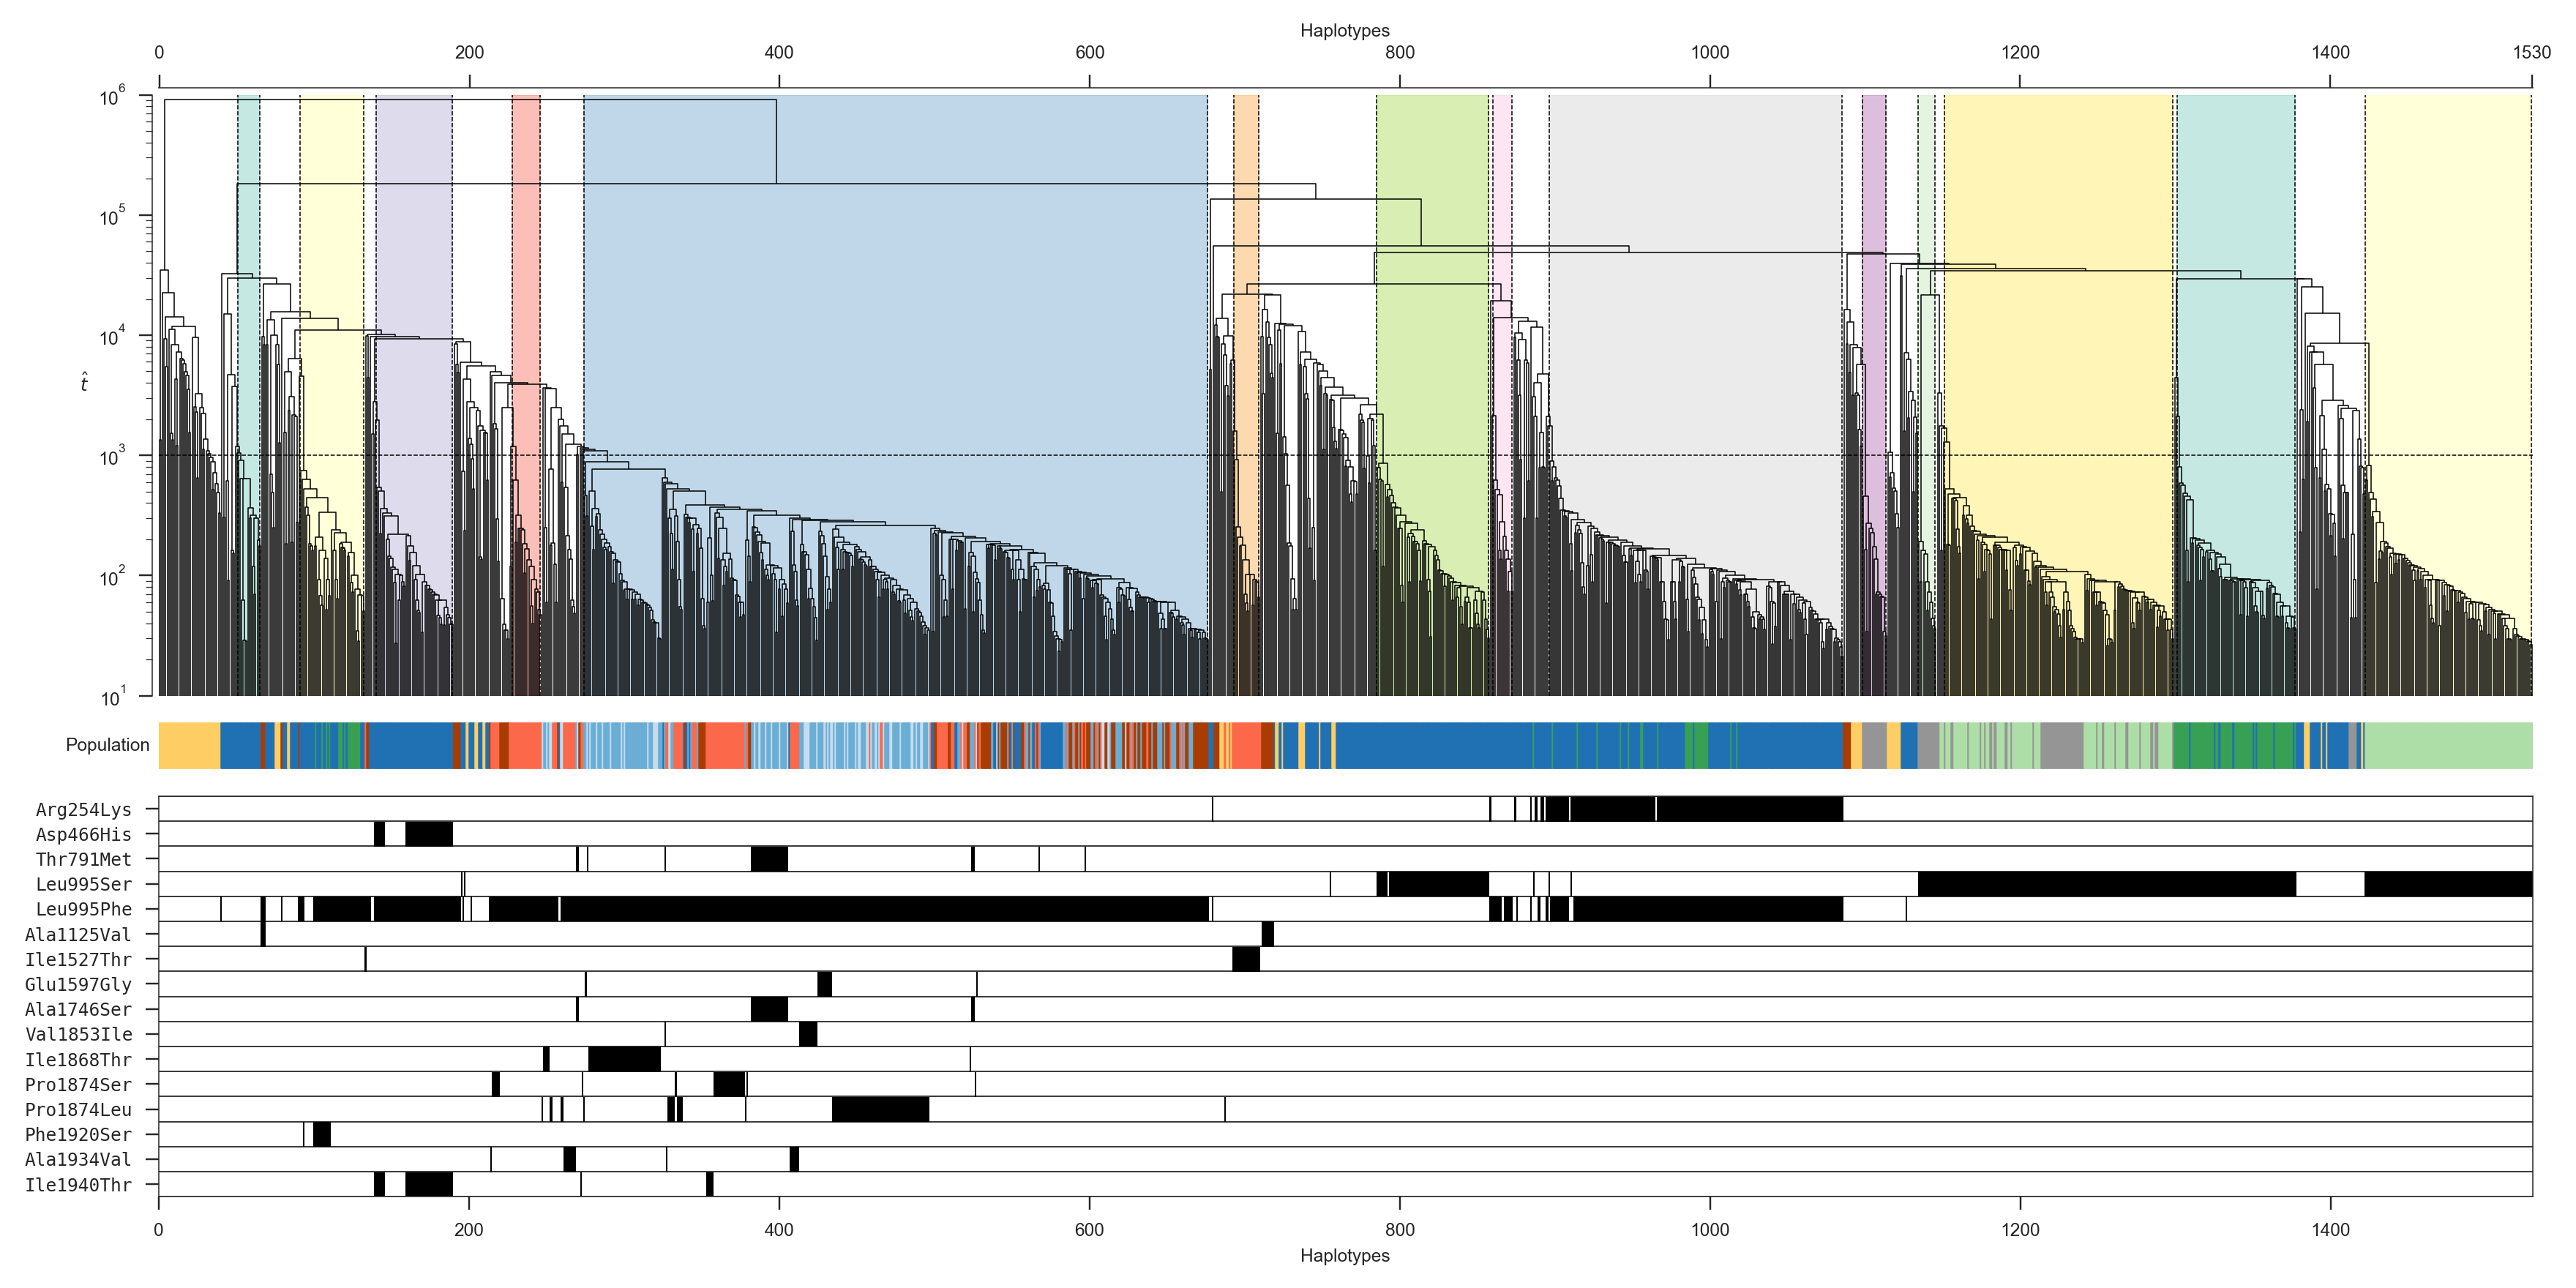

In [103]:
plot_dendrogram(pt_hat_right);

<IPython.core.display.Javascript object>


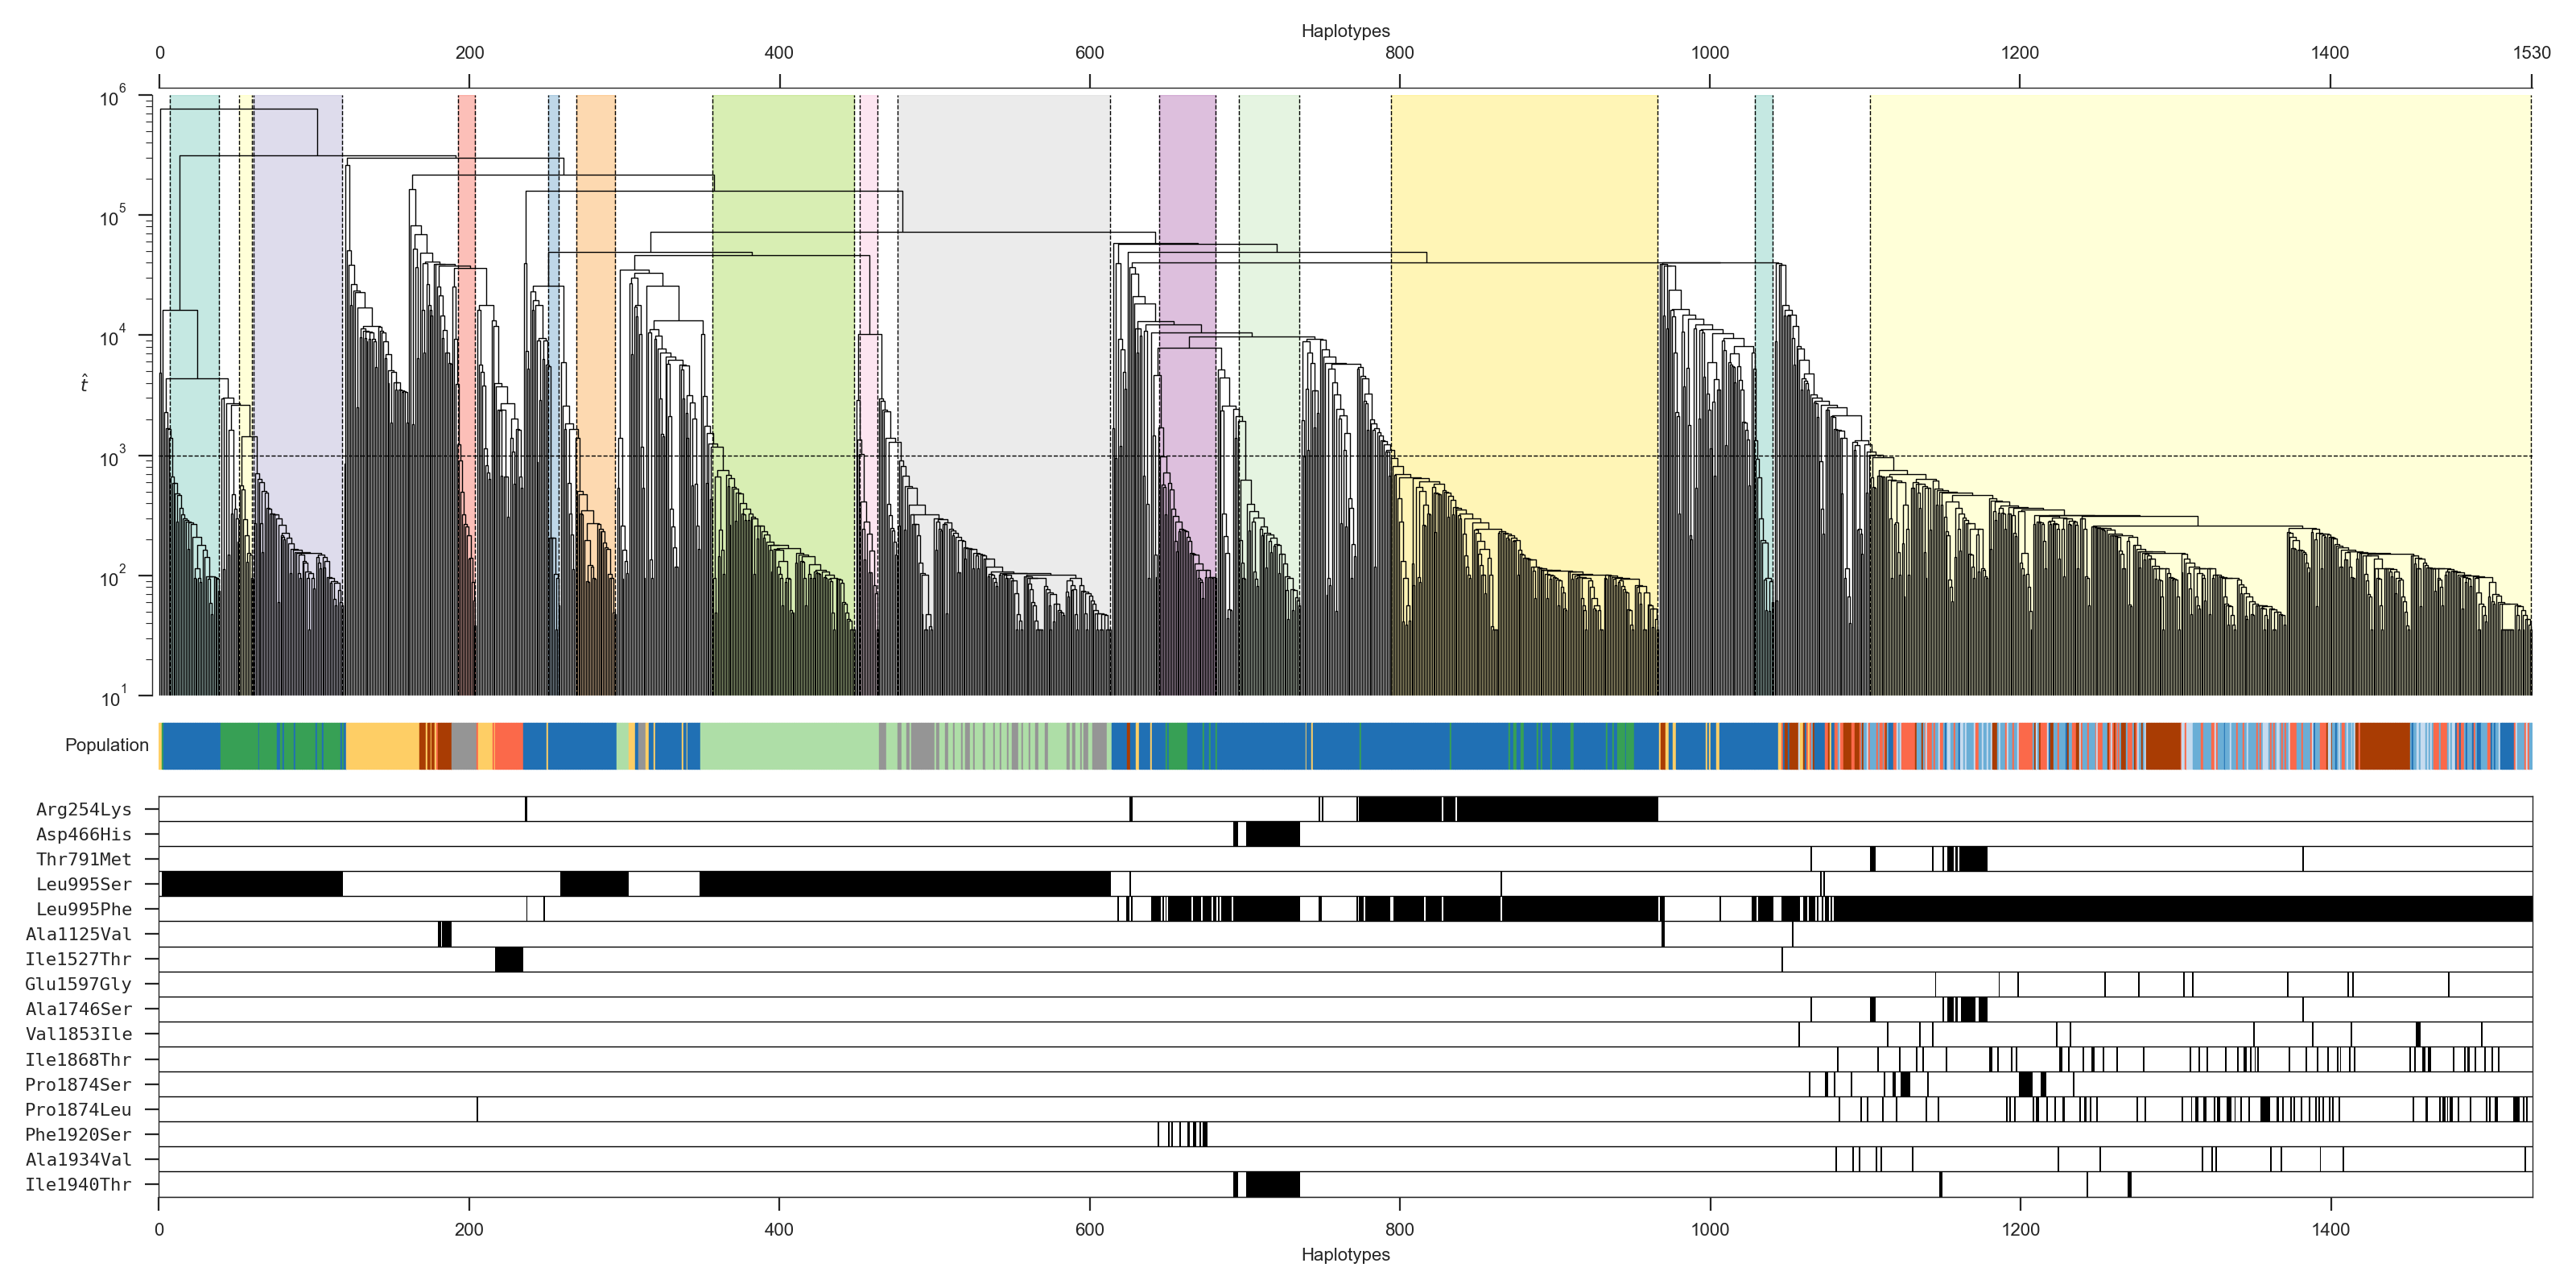

In [104]:
plot_dendrogram(pt_hat_left);

/home/aliman/src/github/alimanfoo/agam-vgsc-report/dependencies/miniconda/envs/agam-report-base/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


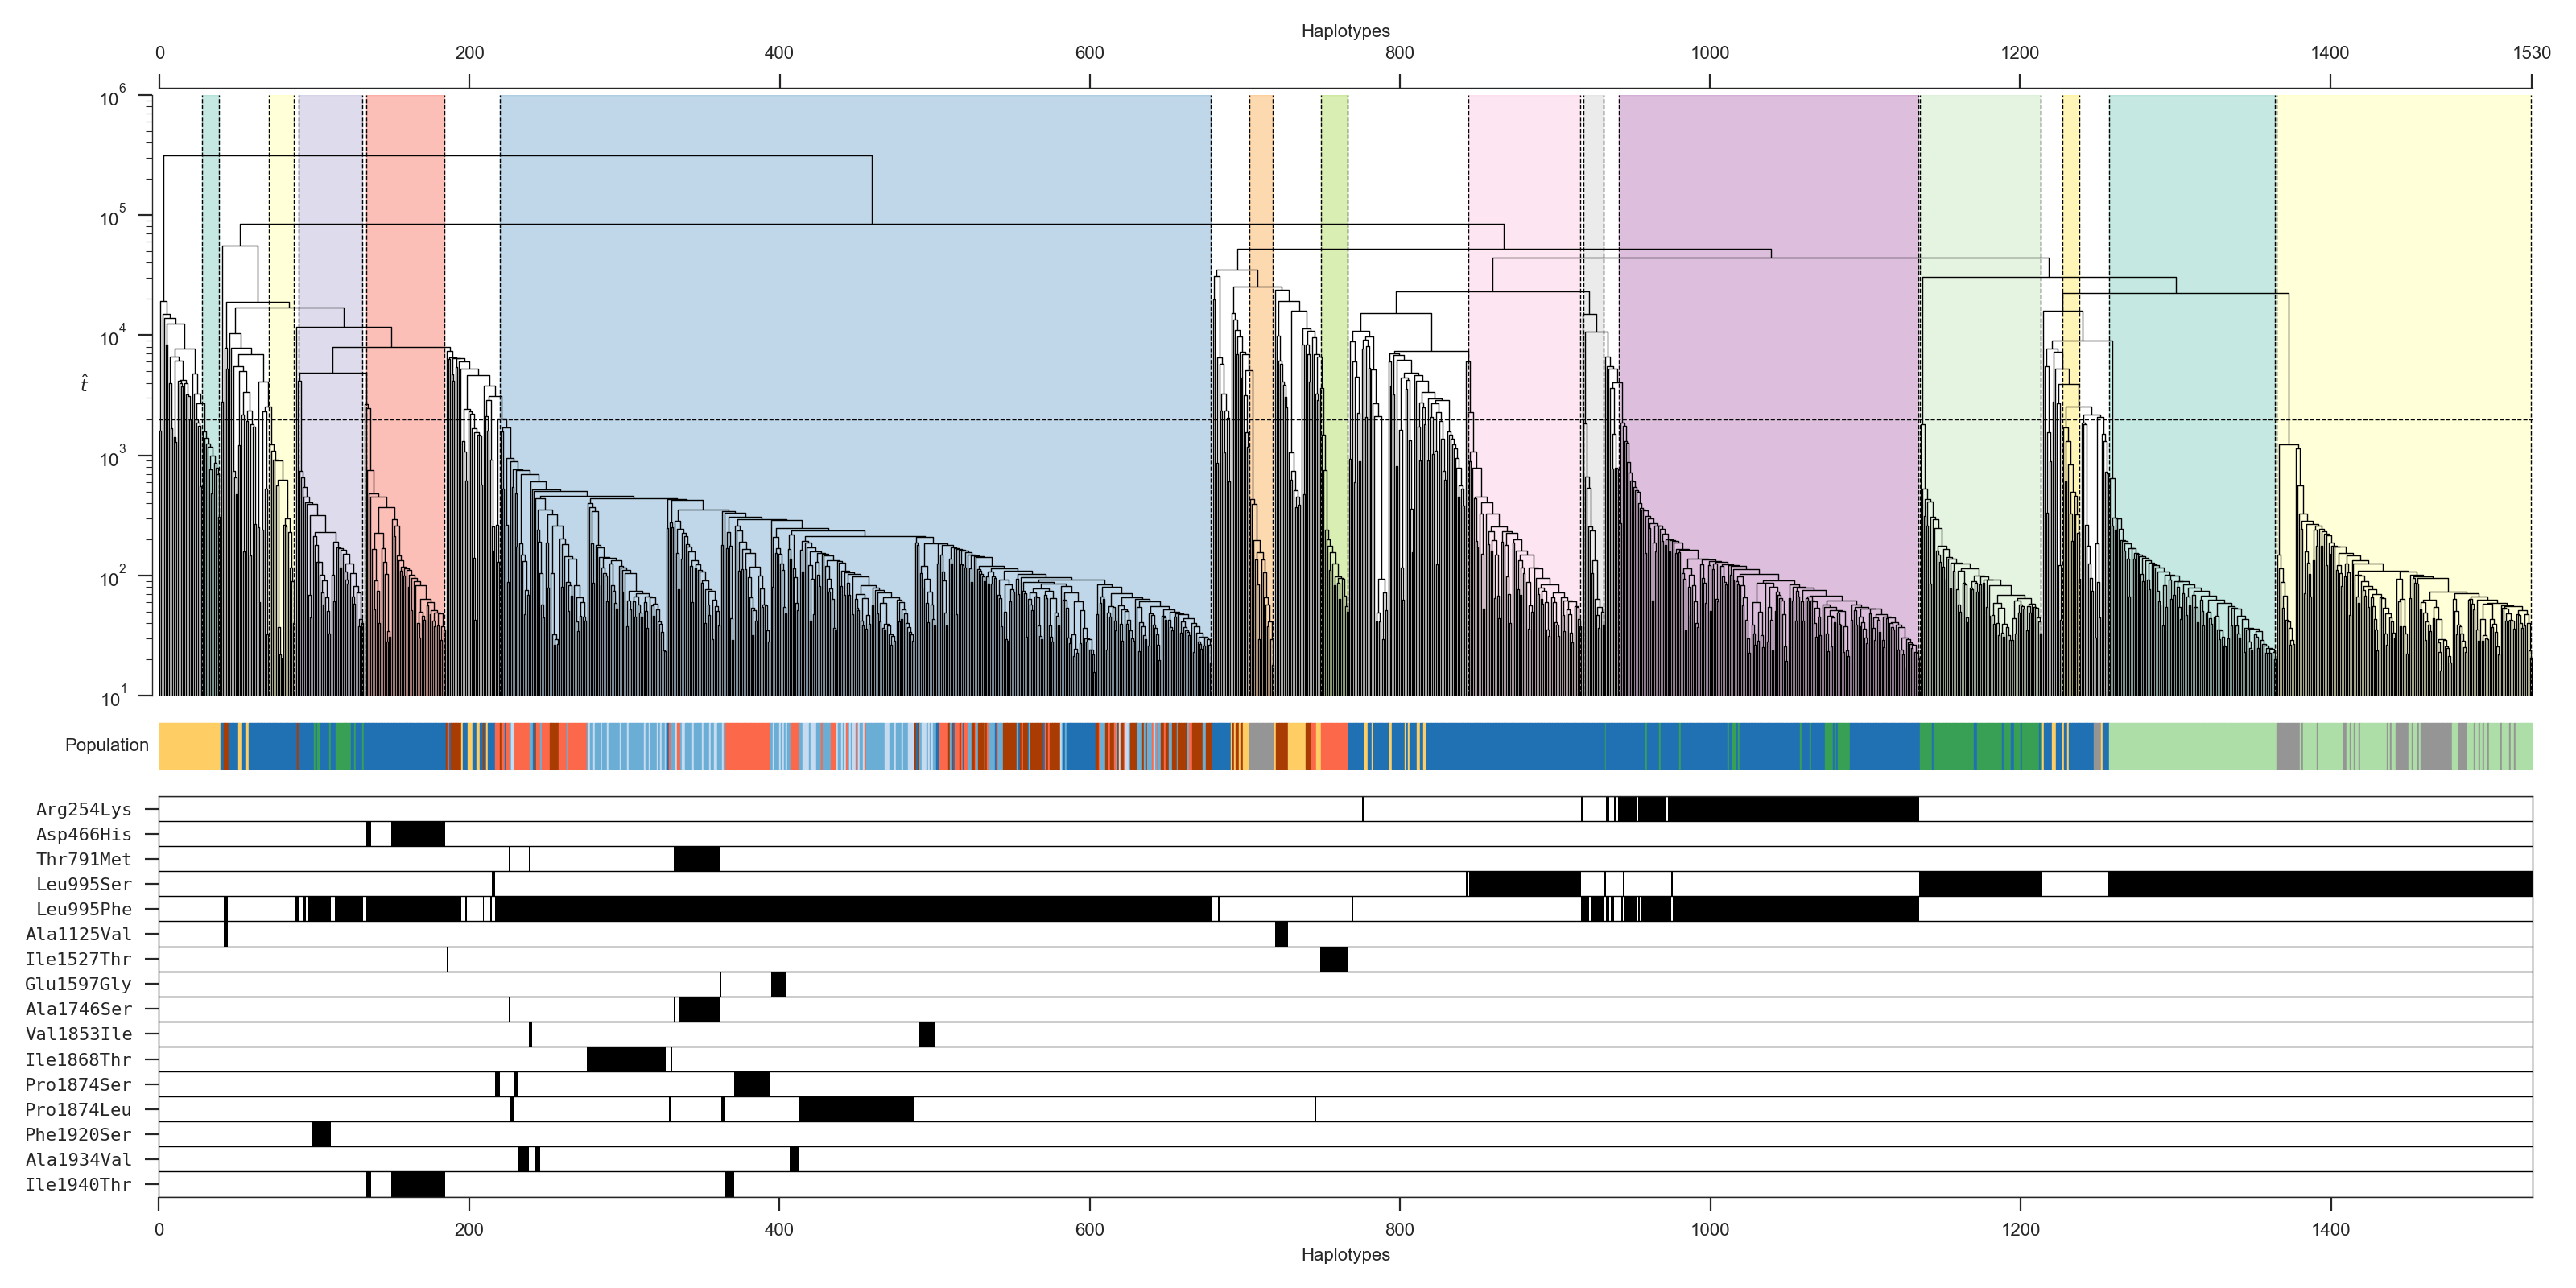

In [105]:
clusters = plot_dendrogram(pt_hat_both, cut_height=2e3)

/home/aliman/src/github/alimanfoo/agam-vgsc-report/dependencies/miniconda/envs/agam-report-base/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


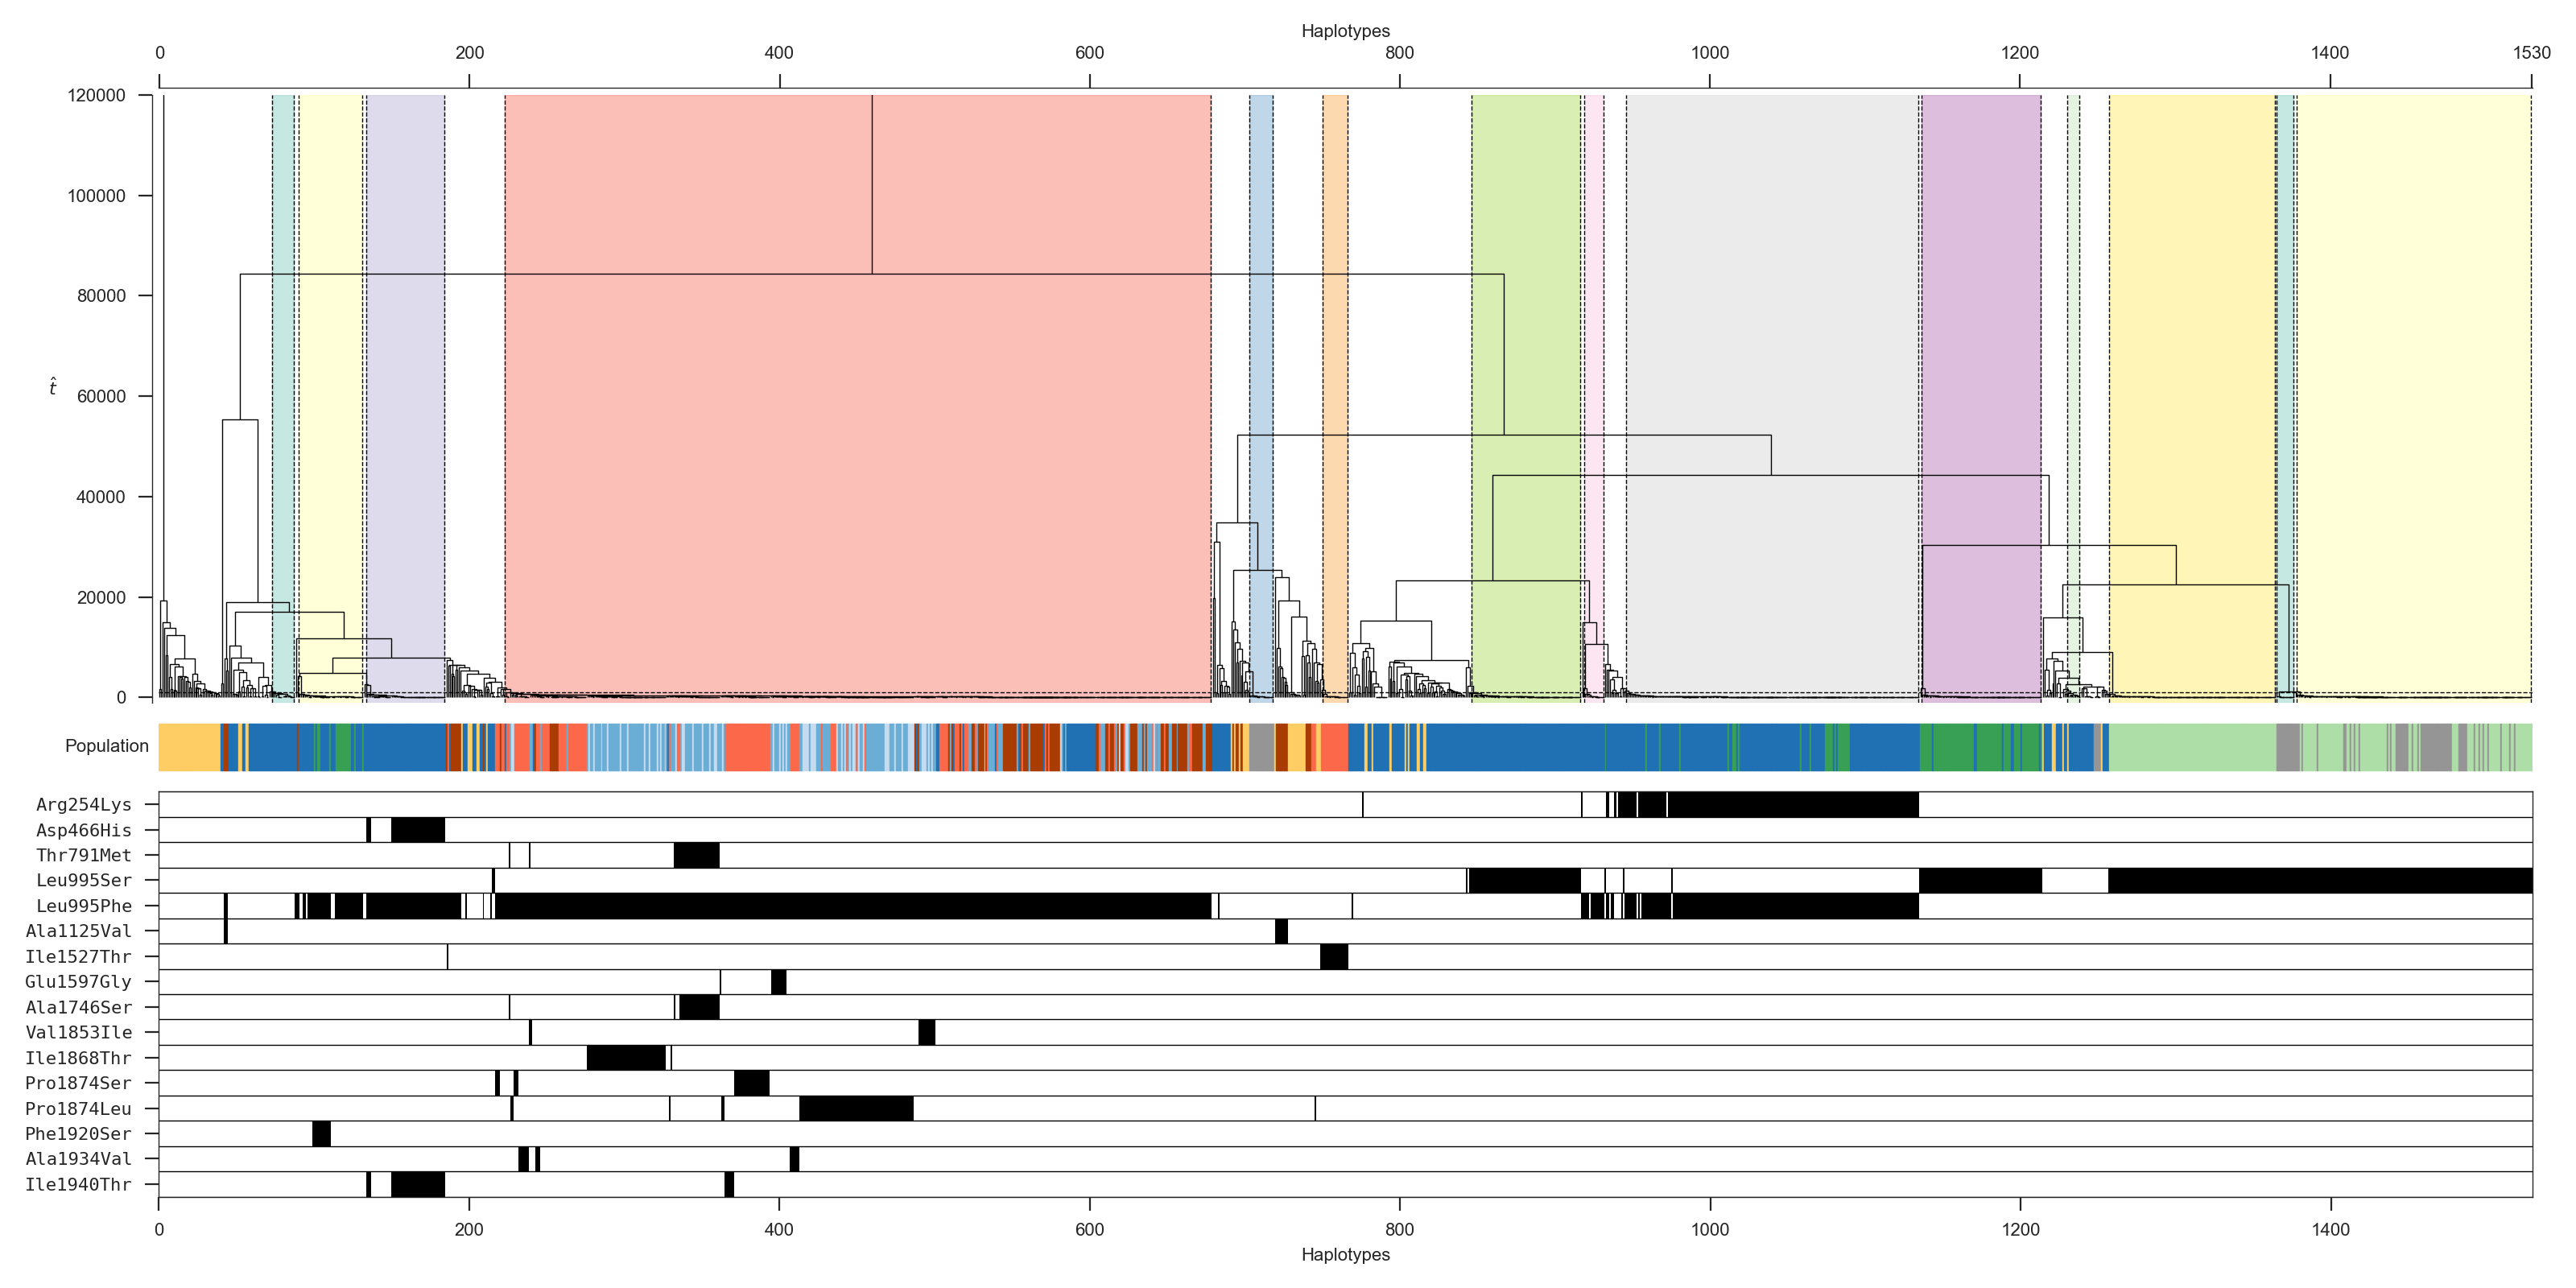

In [106]:
plot_dendrogram(pt_hat_both, yscale='linear', ylim=(-1000, 1.2e5));

## History

In [107]:
len(clusters)

14

In [109]:
f1 = clusters[4]
# f2 = clusters[8]
# f3 = clusters[11]
# f4 = clusters[10]
# f5 = clusters[12]
# s1 = clusters[5]
# s2 = clusters[3]
# s3 = clusters[6]
# s4 = clusters[2]
# l1 = clusters[1]

In [110]:
# rhg = [f1, f2, f3, f4, f5, s1, s2, s3, s4, l1]
# rhg_labels = 'F1 F2 F3 F4 F5 S1 S2 S3 S4 L1'.split()

In [111]:
# for g, l in zip(rhg, rhg_labels):
#     print(l)
#     print(collections.Counter(df_haplotypes.population[sorted(g)]).most_common())

In [112]:
ixs = allel.condensed_coords_within(f1, len(df_haplotypes))

In [113]:
# fig, ax = plt.subplots()
# for g, l in zip(rhg[:5], rhg_labels[:5]):
#     ixs = allel.condensed_coords_within(g, len(df_haplotypes))
#     x = np.log10(pt_hat_both[ixs])
#     sns.distplot(x, bins=np.linspace(1, 3, 20), label=l, hist=False, 
#                  kde_kws=dict(linewidth=2))
# ;

In [114]:
# fig, ax = plt.subplots()
# for g, l in zip(rhg[5:], rhg_labels[5:]):
#     ixs = allel.condensed_coords_within(g, len(df_haplotypes))
#     x = np.log10(pt_hat_both[ixs])
#     sns.distplot(x, bins=np.linspace(1, 3, 20), label=l, hist=False, 
#                  kde_kws=dict(linewidth=2))
# ;

In [117]:

def distplot_cluster_pop_t_hat(cluster):
    cluster = list(cluster)
    pops_clst = df_haplotypes.population[cluster]
    pops_unique = pops_clst.unique()
    pops_subclusters = [np.array(cluster)[(pops_clst == p).values] for p in pops_unique]

    fig, ax = plt.subplots()
    for g, l in zip(pops_subclusters, pops_unique):
        ixs = allel.condensed_coords_within(g, len(df_haplotypes))
        x = np.log10(pt_hat_both[ixs])
        color = phase1_ar3.pop_colors[l]
        sns.distplot(x, bins=np.linspace(1, 3, 20), label=l, hist=False, 
                     kde_kws=dict(linewidth=2, color=color))
        ax.axvline(np.median(x), color=color, lw=2, linestyle='--')
    
    ax.set_xlabel('$\hat{t}$')
    ax.set_ylabel('Density')
    ax.set_xlim(.5, 3.8)
    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels([10, 100, 1000])


/home/aliman/src/github/alimanfoo/agam-vgsc-report/dependencies/miniconda/envs/agam-report-base/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


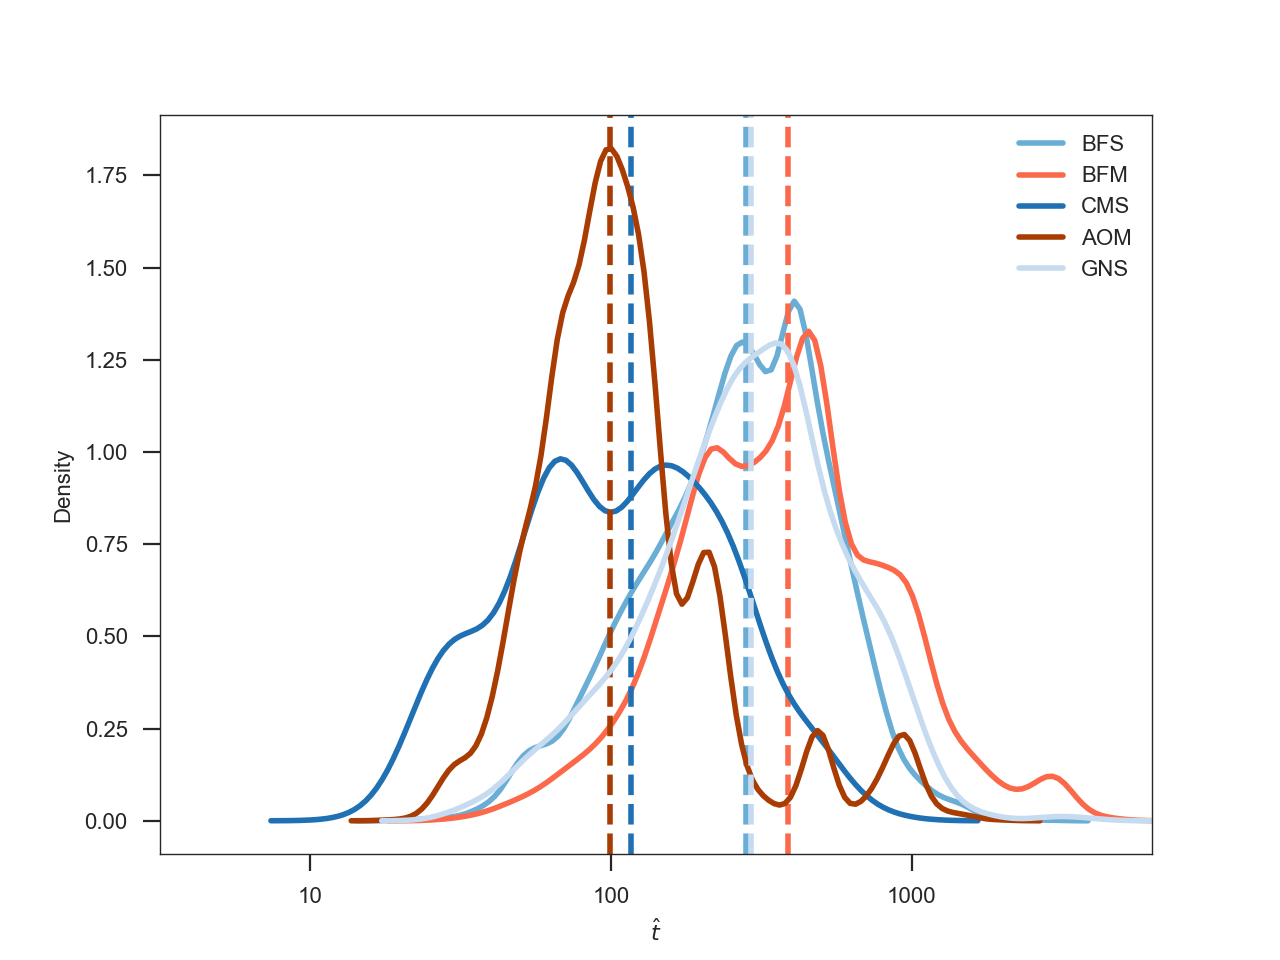

In [118]:
distplot_cluster_pop_t_hat(f1)

In [119]:
# distplot_cluster_pop_t_hat(f2)

In [120]:
# distplot_cluster_pop_t_hat(f3)

In [121]:
# distplot_cluster_pop_t_hat(f4)

In [122]:
# distplot_cluster_pop_t_hat(f5)

In [123]:
# distplot_cluster_pop_t_hat(s1)

In [124]:
# distplot_cluster_pop_t_hat(s2)

In [125]:
# distplot_cluster_pop_t_hat(s3)

In [126]:
# distplot_cluster_pop_t_hat(s4)

In [127]:
# distplot_cluster_pop_t_hat(l1)